## <프로젝트 유형: Multi-Step LSTM Time Series Forecasting>
* windows개념 이용해서 univariate time series forecasting의 방법으로 해결해보고자 함

In [1]:
# Runned_by_JupyterLab


# 2. 이번 Trial 내용
# 모델에 LSTM(units=50) 모델 한 층 더 추가
# ReduceLROnPlateau 적용 factor 0.9, patience = 5
# window_size 120에서 180으로 늘림

---

In [2]:
#Import Library
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout, Bidirectional#,Reshape, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read Data
data_path = '../Big_Data/[DACON]Bit_Trader'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [4]:
# 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 2차원 DF LSTM으로 학습하기 위해 3차원으로 변환시키기
train_x_array = df2d_to_array3d(train_x_df)   #(1380, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(1380, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

In [5]:
# 모델 구성(op1: many-to-one model, op2: many-to-many model(output 모양 바꾸기, return_sequences = True, Window이동 단위 1에서 output 크기로 변경))
# LSTM에 return_sequence=True가 주어지고 Bidirectional이면서 TimeDistributed() 함수가 사용되면 양방향 many-to-many 유형이 된다.https://m.blog.naver.com/chunjein/221589656211
# TimeDistributed() 함수 사용: 모델 layer에 model.add(TimeDistributed(Dense(1, activation='sigmoid')))추가

def build_model():
    seq_len = 180
    model = Sequential()
    model.add(LSTM(100, activation = 'tanh', return_sequences= True, input_shape = [seq_len, 1])) 
    model.add(LSTM(50, activation = 'tanh', return_sequences = True))
    model.add(LSTM(50, activation = 'tanh'))
    model.add(Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    return model

In [6]:
build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 50)           30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 91,251
Trainable params: 91,251
Non-trainable params: 0
_________________________________________________________________


In [7]:
# LearningRateScheduler(scheduler) 구현

# from tensorflow.keras.callbacks import LearningRateScheduler
# # LearningRateScheduler 함수 생성 (epoch이 5이하면 그대로 lr 유지, 아닐시 lr 조정)
# def scheduler(epoch, learning_rate):
#     if epoch < 5:
#         return learning_rate
#     else:
#         return learning_rate * tf.math.exp(-0.1)
# lr = LearningRateScheduler(scheduler)

In [8]:
# test_x_array에 대한 Auto_Regressive한 Prediction 및 valid_pred_array에 예측 결과 기록

# 1) test_pred_array{예측값 모아두는 3차원 배열(120*1 2차원 배열 529개)} 만들기
test_pred_array = np.zeros([len(test_x_array), 120, 1])

# 2) early_stoppage & reduceLR 정의: https://www.dacon.io/competitions/official/235709/codeshare/2453?page=1&dtype=recent 참고)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, patience= 5, mode = 'auto', mindelta = 0.0001, min_lr=0)

# 3) test_x_array로 시계열 Windows 만들기 -> 데이터셋 구성 -> 모델 학습 ||| 예측 -> test_pred_array에 기록 -> window_3d의 첫번째 값 삭제 -> test_pred_array와 window_3d 병합 -> model.predict()에 넣어 예측 -> ***
ep = 30
bs = 120
# idx에 해당하는 샘플 529개 학습: for loop 529번 돌아감
for idx in tqdm(range(test_x_array.shape[0])):  # 529번
    seq_len = 180
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(test_x_array[idx, :, 1][index: index + sequence_length])

    # x_test, y_test 데이터셋 구성
    windows = np.array(windows)  # 1329 * 121의 2차원 배열
    x_test = windows[:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = windows[:, -1]
    
    model = build_model()
    history = model.fit(x_test, y_test, epochs= ep, batch_size= bs, verbose=0, shuffle = True, callbacks=[early_stop, reduceLR])
# shuffle= True 효과 있을까? 미약하게나마 효과 있음. https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력

    # test_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]  # windows.shape (1259, 121), window.shape (120, )
    window_3d = np.reshape(window, (1, window.shape[0], 1))  # (1, 120, 1)
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 test_pred_array에 기록
        test_pred_array[idx, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = test_pred_array[idx, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # test_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

  0%|          | 0/529 [00:00<?, ?it/s]

sample_id :  0 번
loss :  6.329957619228837e-05
lr :  0.00066


  0%|          | 1/529 [00:27<3:58:50, 27.14s/it]

sample_id :  1 번
loss :  4.124488764739804e-05
lr :  0.00066


  0%|          | 2/529 [00:49<3:34:59, 24.48s/it]

sample_id :  2 번
loss :  9.41530373706727e-05
lr :  0.0009


  1%|          | 3/529 [01:12<3:27:59, 23.72s/it]

sample_id :  3 번
loss :  0.00031426839571344425
lr :  0.00073


  1%|          | 4/529 [01:34<3:22:11, 23.11s/it]

sample_id :  4 번
loss :  3.1937722613124464e-05
lr :  0.00066


  1%|          | 5/529 [01:56<3:18:13, 22.70s/it]

sample_id :  5 번
loss :  0.00036102626266387494
lr :  0.00066


  1%|          | 6/529 [02:18<3:14:08, 22.27s/it]

sample_id :  6 번
loss :  0.00024412763439968626
lr :  0.00066


  1%|▏         | 7/529 [02:39<3:11:16, 21.99s/it]

sample_id :  7 번
loss :  0.0003063755086700807
lr :  0.00073


  2%|▏         | 8/529 [03:00<3:08:54, 21.75s/it]

sample_id :  8 번
loss :  0.0001392481379804968
lr :  0.00066


  2%|▏         | 9/529 [03:22<3:08:43, 21.78s/it]

sample_id :  9 번
loss :  0.0004421973974211724
lr :  0.00073


  2%|▏         | 10/529 [03:43<3:06:52, 21.60s/it]

sample_id :  10 번
loss :  9.342268560515923e-05
lr :  0.00073


  2%|▏         | 11/529 [04:05<3:05:54, 21.53s/it]

sample_id :  11 번
loss :  0.00024063360341717788
lr :  0.00073


  2%|▏         | 12/529 [04:26<3:05:56, 21.58s/it]

sample_id :  12 번
loss :  4.924065351519801e-05
lr :  0.00066


  2%|▏         | 13/529 [04:48<3:05:02, 21.52s/it]

sample_id :  13 번
loss :  0.00017920778436344303
lr :  0.00066


  3%|▎         | 14/529 [05:09<3:03:55, 21.43s/it]

sample_id :  14 번
loss :  0.00023977555830425446
lr :  0.00073


  3%|▎         | 15/529 [05:31<3:03:57, 21.47s/it]

sample_id :  15 번
loss :  0.00018013208729562174
lr :  0.00073


  3%|▎         | 16/529 [05:52<3:03:53, 21.51s/it]

sample_id :  16 번
loss :  9.47338904052572e-05
lr :  0.00066


  3%|▎         | 17/529 [06:14<3:03:37, 21.52s/it]

sample_id :  17 번
loss :  0.00043094074402608016
lr :  0.001


  3%|▎         | 18/529 [06:35<3:03:16, 21.52s/it]

sample_id :  18 번
loss :  0.0002779798015460428
lr :  0.00066


  4%|▎         | 19/529 [06:57<3:02:50, 21.51s/it]

sample_id :  19 번
loss :  0.00041491862923781497
lr :  0.00073


  4%|▍         | 20/529 [07:18<3:02:23, 21.50s/it]

sample_id :  20 번
loss :  0.0003351806238677362
lr :  0.00066


  4%|▍         | 21/529 [07:40<3:02:19, 21.53s/it]

sample_id :  21 번
loss :  0.0004497642414854083
lr :  0.001


  4%|▍         | 22/529 [08:01<2:59:55, 21.29s/it]

sample_id :  22 번
loss :  0.00012155030018555232
lr :  0.00066


  4%|▍         | 23/529 [08:22<3:00:05, 21.36s/it]

sample_id :  23 번
loss :  0.0005422298569469911
lr :  0.001


  5%|▍         | 24/529 [08:44<3:00:17, 21.42s/it]

sample_id :  24 번
loss :  0.00020879284978805
lr :  0.00066


  5%|▍         | 25/529 [09:05<3:00:24, 21.48s/it]

sample_id :  25 번
loss :  0.0003068040234933501
lr :  0.001


  5%|▍         | 26/529 [09:27<3:00:56, 21.58s/it]

sample_id :  26 번
loss :  0.00042596148526326315
lr :  0.00081


  5%|▌         | 27/529 [09:48<2:58:22, 21.32s/it]

sample_id :  27 번
loss :  0.00038709890526922124
lr :  0.00073


  5%|▌         | 28/529 [10:09<2:58:57, 21.43s/it]

sample_id :  28 번
loss :  0.000333279028132533
lr :  0.001


  5%|▌         | 29/529 [10:31<2:59:01, 21.48s/it]

sample_id :  29 번
loss :  7.789118306806856e-05
lr :  0.00066


  6%|▌         | 30/529 [10:52<2:56:58, 21.28s/it]

sample_id :  30 번
loss :  9.538825456354203e-05
lr :  0.00066


  6%|▌         | 31/529 [11:14<2:58:04, 21.45s/it]

sample_id :  31 번
loss :  4.019886207081544e-05
lr :  0.00066


  6%|▌         | 32/529 [11:35<2:58:24, 21.54s/it]

sample_id :  32 번
loss :  0.00044302728642290885
lr :  0.00073


  6%|▌         | 33/529 [11:56<2:56:34, 21.36s/it]

sample_id :  33 번
loss :  0.0003003226264474682
lr :  0.00073


  6%|▋         | 34/529 [12:18<2:56:33, 21.40s/it]

sample_id :  34 번
loss :  0.0001840247795742325
lr :  0.00073


  7%|▋         | 35/529 [12:40<2:58:07, 21.63s/it]

sample_id :  35 번
loss :  0.00039686277727487716
lr :  0.001


  7%|▋         | 36/529 [13:01<2:55:36, 21.37s/it]

sample_id :  36 번
loss :  0.00034614930631751326
lr :  0.00073


  7%|▋         | 37/529 [13:23<2:56:48, 21.56s/it]

sample_id :  37 번
loss :  0.0003547723178543598
lr :  0.00073


  7%|▋         | 38/529 [13:44<2:54:31, 21.33s/it]

sample_id :  38 번
loss :  0.00012406526917862194
lr :  0.00073


  7%|▋         | 39/529 [14:06<2:55:56, 21.54s/it]

sample_id :  39 번
loss :  0.00013139390343337243
lr :  0.00066


  8%|▊         | 40/529 [14:27<2:56:08, 21.61s/it]

sample_id :  40 번
loss :  0.00025516717554981957
lr :  0.00066


  8%|▊         | 41/529 [14:48<2:53:39, 21.35s/it]

sample_id :  41 번
loss :  0.0001351995048781366
lr :  0.00066


  8%|▊         | 42/529 [15:10<2:54:48, 21.54s/it]

sample_id :  42 번
loss :  0.00013870456465888922
lr :  0.00066


  8%|▊         | 43/529 [15:31<2:52:37, 21.31s/it]

sample_id :  43 번
loss :  4.709020140277415e-05
lr :  0.00066


  8%|▊         | 44/529 [15:53<2:54:24, 21.58s/it]

sample_id :  44 번
loss :  7.576492054425211e-05
lr :  0.0009


  9%|▊         | 45/529 [16:14<2:51:33, 21.27s/it]

sample_id :  45 번
loss :  5.7491506898815114e-05
lr :  0.00066


  9%|▊         | 46/529 [16:36<2:53:58, 21.61s/it]

sample_id :  46 번
loss :  0.00013143866678734417
lr :  0.00066


  9%|▉         | 47/529 [16:57<2:51:39, 21.37s/it]

sample_id :  47 번
loss :  6.141905939783023e-05
lr :  0.00066


  9%|▉         | 48/529 [17:19<2:53:31, 21.65s/it]

sample_id :  48 번
loss :  0.0001649225865530737
lr :  0.00066


  9%|▉         | 49/529 [17:40<2:51:17, 21.41s/it]

sample_id :  49 번
loss :  0.00034251069475091167
lr :  0.00073


  9%|▉         | 50/529 [18:02<2:53:20, 21.71s/it]

sample_id :  50 번
loss :  0.00028042835913586107
lr :  0.00066


 10%|▉         | 51/529 [18:23<2:50:50, 21.44s/it]

sample_id :  51 번
loss :  0.0002059480960499705
lr :  0.00066


 10%|▉         | 52/529 [18:46<2:53:09, 21.78s/it]

sample_id :  52 번
loss :  3.080319776329621e-05
lr :  0.00066


 10%|█         | 53/529 [19:07<2:50:41, 21.51s/it]

sample_id :  53 번
loss :  0.00011476674681383569
lr :  0.00066


 10%|█         | 54/529 [19:29<2:53:05, 21.86s/it]

sample_id :  54 번
loss :  0.0002643015002686176
lr :  0.00066


 10%|█         | 55/529 [19:50<2:50:25, 21.57s/it]

sample_id :  55 번
loss :  0.0002015966620471785
lr :  0.00066


 11%|█         | 56/529 [20:11<2:48:08, 21.33s/it]

sample_id :  56 번
loss :  0.0003034086559646319
lr :  0.00073


 11%|█         | 57/529 [20:33<2:50:15, 21.64s/it]

sample_id :  57 번
loss :  0.0002156101249416069
lr :  0.00066


 11%|█         | 58/529 [20:54<2:48:06, 21.41s/it]

sample_id :  58 번
loss :  0.00014929918334330024
lr :  0.00066


 11%|█         | 59/529 [21:17<2:50:08, 21.72s/it]

sample_id :  59 번
loss :  0.00010542838132335922
lr :  0.00066


 11%|█▏        | 60/529 [21:38<2:47:50, 21.47s/it]

sample_id :  60 번
loss :  0.00016795126561301095
lr :  0.001


 12%|█▏        | 61/529 [22:01<2:51:14, 21.95s/it]

sample_id :  61 번
loss :  0.00027175172933787447
lr :  0.00066


 12%|█▏        | 62/529 [22:22<2:48:12, 21.61s/it]

sample_id :  62 번
loss :  0.0003061778975693001
lr :  0.00073


 12%|█▏        | 63/529 [22:43<2:46:29, 21.44s/it]

sample_id :  63 번
loss :  0.0002005846808886651
lr :  0.001


 12%|█▏        | 64/529 [23:05<2:49:02, 21.81s/it]

sample_id :  64 번
loss :  0.0003733707108510405
lr :  0.00066


 12%|█▏        | 65/529 [23:26<2:46:37, 21.55s/it]

sample_id :  65 번
loss :  0.0002967212313979948
lr :  0.0009


 12%|█▏        | 66/529 [23:49<2:49:10, 21.92s/it]

sample_id :  66 번
loss :  0.000180669865374639
lr :  0.00066


 13%|█▎        | 67/529 [24:10<2:46:45, 21.66s/it]

sample_id :  67 번
loss :  0.0001671877523143935
lr :  0.00066


 13%|█▎        | 68/529 [24:31<2:44:40, 21.43s/it]

sample_id :  68 번
loss :  0.00019838577115036753
lr :  0.001


 13%|█▎        | 69/529 [24:54<2:47:34, 21.86s/it]

sample_id :  69 번
loss :  0.00015765482364544757
lr :  0.00066


 13%|█▎        | 70/529 [25:15<2:45:08, 21.59s/it]

sample_id :  70 번
loss :  3.5173697989748394e-05
lr :  0.00066


 13%|█▎        | 71/529 [25:36<2:43:22, 21.40s/it]

sample_id :  71 번
loss :  0.00027308692741833063
lr :  0.00066


 14%|█▎        | 72/529 [25:59<2:46:23, 21.85s/it]

sample_id :  72 번
loss :  0.0002979275945399665
lr :  0.00073


 14%|█▍        | 73/529 [26:19<2:42:49, 21.42s/it]

sample_id :  73 번
loss :  0.00023981910513510448
lr :  0.00066


 14%|█▍        | 74/529 [26:40<2:42:11, 21.39s/it]

sample_id :  74 번
loss :  0.00016415401445528892
lr :  0.00066


 14%|█▍        | 75/529 [27:03<2:45:20, 21.85s/it]

sample_id :  75 번
loss :  0.00032901963278467926
lr :  0.00066


 14%|█▍        | 76/529 [27:24<2:42:51, 21.57s/it]

sample_id :  76 번
loss :  0.000599757796079635
lr :  0.00073


 15%|█▍        | 77/529 [27:45<2:40:52, 21.35s/it]

sample_id :  77 번
loss :  0.00010505791230583944
lr :  0.00066


 15%|█▍        | 78/529 [28:08<2:44:11, 21.84s/it]

sample_id :  78 번
loss :  0.0002519619413307814
lr :  0.00073


 15%|█▍        | 79/529 [28:29<2:40:45, 21.44s/it]

sample_id :  79 번
loss :  0.00010834211984771056
lr :  0.001


 15%|█▌        | 80/529 [28:50<2:39:26, 21.31s/it]

sample_id :  80 번
loss :  0.0001521473215000426
lr :  0.00066


 15%|█▌        | 81/529 [29:13<2:43:16, 21.87s/it]

sample_id :  81 번
loss :  0.0005326004143448172
lr :  0.00073


 16%|█▌        | 82/529 [29:34<2:40:38, 21.56s/it]

sample_id :  82 번
loss :  0.00029110361208220336
lr :  0.00066


 16%|█▌        | 83/529 [29:54<2:38:48, 21.36s/it]

sample_id :  83 번
loss :  0.00045011686696632113
lr :  0.00073


 16%|█▌        | 84/529 [30:17<2:41:45, 21.81s/it]

sample_id :  84 번
loss :  0.00018983657200070405
lr :  0.00066


 16%|█▌        | 85/529 [30:38<2:39:42, 21.58s/it]

sample_id :  85 번
loss :  0.00032046953011764367
lr :  0.001


 16%|█▋        | 86/529 [30:59<2:37:47, 21.37s/it]

sample_id :  86 번
loss :  0.00039500963910183
lr :  0.00073


 16%|█▋        | 87/529 [31:22<2:41:30, 21.93s/it]

sample_id :  87 번
loss :  0.00040468048298299576
lr :  0.00073


 17%|█▋        | 88/529 [31:43<2:39:00, 21.63s/it]

sample_id :  88 번
loss :  0.00019443758240620526
lr :  0.00073


 17%|█▋        | 89/529 [32:04<2:37:08, 21.43s/it]

sample_id :  89 번
loss :  7.626150494270117e-05
lr :  0.00073


 17%|█▋        | 90/529 [32:28<2:41:14, 22.04s/it]

sample_id :  90 번
loss :  0.00021480584309923402
lr :  0.00066


 17%|█▋        | 91/529 [32:49<2:38:47, 21.75s/it]

sample_id :  91 번
loss :  0.00018353961526155642
lr :  0.00066


 17%|█▋        | 92/529 [33:10<2:36:56, 21.55s/it]

sample_id :  92 번
loss :  0.00020716807017232165
lr :  0.00066


 18%|█▊        | 93/529 [33:31<2:35:19, 21.38s/it]

sample_id :  93 번
loss :  0.00017320685475989727
lr :  0.00073


 18%|█▊        | 94/529 [33:54<2:39:21, 21.98s/it]

sample_id :  94 번
loss :  0.0006124742653025151
lr :  0.00073


 18%|█▊        | 95/529 [34:15<2:36:17, 21.61s/it]

sample_id :  95 번
loss :  8.08793823772636e-05
lr :  0.00066


 18%|█▊        | 96/529 [34:36<2:34:08, 21.36s/it]

sample_id :  96 번
loss :  8.236061777469792e-05
lr :  0.00066


 18%|█▊        | 97/529 [34:59<2:38:36, 22.03s/it]

sample_id :  97 번
loss :  0.001701036222501222
lr :  0.00081


 19%|█▊        | 98/529 [35:20<2:35:56, 21.71s/it]

sample_id :  98 번
loss :  9.391000644127925e-05
lr :  0.00066


 19%|█▊        | 99/529 [35:41<2:33:46, 21.46s/it]

sample_id :  99 번
loss :  0.00019044790175823793
lr :  0.00066


 19%|█▉        | 100/529 [36:02<2:32:14, 21.29s/it]

sample_id :  100 번
loss :  0.00021258705572387883
lr :  0.001


 19%|█▉        | 101/529 [36:26<2:36:32, 21.94s/it]

sample_id :  101 번
loss :  8.271823149801483e-05
lr :  0.00066


 19%|█▉        | 102/529 [36:47<2:34:07, 21.66s/it]

sample_id :  102 번
loss :  0.00045688917471140196
lr :  0.001


 19%|█▉        | 103/529 [37:07<2:32:02, 21.41s/it]

sample_id :  103 번
loss :  0.0001259322699321142
lr :  0.00066


 20%|█▉        | 104/529 [37:29<2:30:54, 21.30s/it]

sample_id :  104 번
loss :  0.00010775261535969492
lr :  0.00073


 20%|█▉        | 105/529 [37:52<2:35:47, 22.05s/it]

sample_id :  105 번
loss :  0.00013180177029046704
lr :  0.00073


 20%|██        | 106/529 [38:13<2:33:01, 21.70s/it]

sample_id :  106 번
loss :  9.013729023134873e-05
lr :  0.00066


 20%|██        | 107/529 [38:34<2:30:17, 21.37s/it]

sample_id :  107 번
loss :  0.00015314784896623319
lr :  0.00066


 20%|██        | 108/529 [38:55<2:29:11, 21.26s/it]

sample_id :  108 번
loss :  4.365586049837667e-05
lr :  0.00066


 21%|██        | 109/529 [39:19<2:34:05, 22.01s/it]

sample_id :  109 번
loss :  0.00016405036337199848
lr :  0.00066


 21%|██        | 110/529 [39:40<2:31:36, 21.71s/it]

sample_id :  110 번
loss :  1.1727994823467346e-05
lr :  0.00066


 21%|██        | 111/529 [40:00<2:29:34, 21.47s/it]

sample_id :  111 번
loss :  0.00026191700943353416
lr :  0.00066


 21%|██        | 112/529 [40:21<2:27:21, 21.20s/it]

sample_id :  112 번
loss :  0.0002589119142948652
lr :  0.00066


 21%|██▏       | 113/529 [40:46<2:33:45, 22.18s/it]

sample_id :  113 번
loss :  0.000324633830374346
lr :  0.00066


 22%|██▏       | 114/529 [41:06<2:30:47, 21.80s/it]

sample_id :  114 번
loss :  0.00018718105583456348
lr :  0.00066


 22%|██▏       | 115/529 [41:27<2:28:40, 21.55s/it]

sample_id :  115 번
loss :  0.0002135653149609798
lr :  0.00066


 22%|██▏       | 116/529 [41:48<2:26:53, 21.34s/it]

sample_id :  116 번
loss :  0.0002175101515944011
lr :  0.00073


 22%|██▏       | 117/529 [42:12<2:32:16, 22.18s/it]

sample_id :  117 번
loss :  0.00023295513468181282
lr :  0.00066


 22%|██▏       | 118/529 [42:33<2:28:47, 21.72s/it]

sample_id :  118 번
loss :  0.0001673162121799937
lr :  0.00066


 22%|██▏       | 119/529 [42:54<2:26:50, 21.49s/it]

sample_id :  119 번
loss :  7.013928910049947e-05
lr :  0.00066


 23%|██▎       | 120/529 [43:15<2:25:23, 21.33s/it]

sample_id :  120 번
loss :  0.000273075918888392
lr :  0.0009


 23%|██▎       | 121/529 [43:36<2:24:50, 21.30s/it]

sample_id :  121 번
loss :  0.0004459858015484508
lr :  0.00081


 23%|██▎       | 122/529 [44:00<2:30:29, 22.18s/it]

sample_id :  122 번
loss :  0.00032771716454669094
lr :  0.001


 23%|██▎       | 123/529 [44:21<2:26:56, 21.71s/it]

sample_id :  123 번
loss :  0.00047182058699462437
lr :  0.00073


 23%|██▎       | 124/529 [44:42<2:25:39, 21.58s/it]

sample_id :  124 번
loss :  0.00030738332550495
lr :  0.001


 24%|██▎       | 125/529 [45:03<2:24:19, 21.43s/it]

sample_id :  125 번
loss :  8.558221116823784e-05
lr :  0.00066


 24%|██▍       | 126/529 [45:28<2:29:30, 22.26s/it]

sample_id :  126 번
loss :  0.00013192212388971533
lr :  0.00066


 24%|██▍       | 127/529 [45:49<2:26:36, 21.88s/it]

sample_id :  127 번
loss :  9.576607522319923e-05
lr :  0.00066


 24%|██▍       | 128/529 [46:10<2:24:35, 21.63s/it]

sample_id :  128 번
loss :  0.0001023297206830937
lr :  0.00066


 24%|██▍       | 129/529 [46:31<2:22:53, 21.43s/it]

sample_id :  129 번
loss :  0.00010411837419200404
lr :  0.00066


 25%|██▍       | 130/529 [46:52<2:22:29, 21.43s/it]

sample_id :  130 번
loss :  0.00023549485930447094
lr :  0.00073


 25%|██▍       | 131/529 [47:17<2:28:50, 22.44s/it]

sample_id :  131 번
loss :  7.895970577815876e-05
lr :  0.00073


 25%|██▍       | 132/529 [47:38<2:25:46, 22.03s/it]

sample_id :  132 번
loss :  0.00025235923471044223
lr :  0.00073


 25%|██▌       | 133/529 [47:59<2:23:27, 21.74s/it]

sample_id :  133 번
loss :  7.478507367984933e-05
lr :  0.0009


 25%|██▌       | 134/529 [48:20<2:20:53, 21.40s/it]

sample_id :  134 번
loss :  3.9925806225705474e-05
lr :  0.00066


 26%|██▌       | 135/529 [48:41<2:21:09, 21.50s/it]

sample_id :  135 번
loss :  0.0002898066881846006
lr :  0.00066


 26%|██▌       | 136/529 [49:06<2:26:41, 22.40s/it]

sample_id :  136 번
loss :  0.00016835441893606282
lr :  0.00073


 26%|██▌       | 137/529 [49:27<2:23:42, 22.00s/it]

sample_id :  137 번
loss :  0.00033007873185530453
lr :  0.00073


 26%|██▌       | 138/529 [49:48<2:21:20, 21.69s/it]

sample_id :  138 번
loss :  0.0002266604254428869
lr :  0.00066


 26%|██▋       | 139/529 [50:09<2:19:46, 21.50s/it]

sample_id :  139 번
loss :  0.0005054372289292577
lr :  0.0009


 26%|██▋       | 140/529 [50:30<2:18:38, 21.38s/it]

sample_id :  140 번
loss :  0.00012180546555532962
lr :  0.00066


 27%|██▋       | 141/529 [50:55<2:24:51, 22.40s/it]

sample_id :  141 번
loss :  0.0003209531446938264
lr :  0.00073


 27%|██▋       | 142/529 [51:16<2:21:46, 21.98s/it]

sample_id :  142 번
loss :  2.3913736971025492e-05
lr :  0.00066


 27%|██▋       | 143/529 [51:37<2:19:25, 21.67s/it]

sample_id :  143 번
loss :  0.00044729305024230053
lr :  0.00081


 27%|██▋       | 144/529 [51:58<2:17:50, 21.48s/it]

sample_id :  144 번
loss :  0.000232991325829001
lr :  0.001


 27%|██▋       | 145/529 [52:19<2:16:36, 21.35s/it]

sample_id :  145 번
loss :  0.00021701351282349147
lr :  0.00066


 28%|██▊       | 146/529 [52:44<2:23:39, 22.50s/it]

sample_id :  146 번
loss :  0.00013195376863142514
lr :  0.00066


 28%|██▊       | 147/529 [53:05<2:20:32, 22.08s/it]

sample_id :  147 번
loss :  0.00012486563239897522
lr :  0.00066


 28%|██▊       | 148/529 [53:26<2:18:16, 21.78s/it]

sample_id :  148 번
loss :  4.9199339389920255e-05
lr :  0.00066


 28%|██▊       | 149/529 [53:47<2:16:29, 21.55s/it]

sample_id :  149 번
loss :  0.00047132450856347634
lr :  0.00073


 28%|██▊       | 150/529 [54:08<2:15:29, 21.45s/it]

sample_id :  150 번
loss :  0.00021885762883337048
lr :  0.001


 29%|██▊       | 151/529 [54:34<2:22:23, 22.60s/it]

sample_id :  151 번
loss :  0.0001139163570824212
lr :  0.00081


 29%|██▊       | 152/529 [54:55<2:19:06, 22.14s/it]

sample_id :  152 번
loss :  9.081922660370492e-05
lr :  0.00066


 29%|██▉       | 153/529 [55:16<2:17:02, 21.87s/it]

sample_id :  153 번
loss :  0.0003819894142685034
lr :  0.00081


 29%|██▉       | 154/529 [55:37<2:15:11, 21.63s/it]

sample_id :  154 번
loss :  0.0002958791313125512
lr :  0.00066


 29%|██▉       | 155/529 [55:58<2:13:48, 21.47s/it]

sample_id :  155 번
loss :  0.00023450752677224278
lr :  0.001


 29%|██▉       | 156/529 [56:23<2:20:35, 22.62s/it]

sample_id :  156 번
loss :  0.0004892823095274181
lr :  0.00073


 30%|██▉       | 157/529 [56:45<2:18:31, 22.34s/it]

sample_id :  157 번
loss :  0.00017833099759737646
lr :  0.00066


 30%|██▉       | 158/529 [57:06<2:15:50, 21.97s/it]

sample_id :  158 번
loss :  0.0003344870981085716
lr :  0.00073


 30%|███       | 159/529 [57:27<2:13:59, 21.73s/it]

sample_id :  159 번
loss :  8.89448701968926e-05
lr :  0.00066


 30%|███       | 160/529 [57:48<2:12:21, 21.52s/it]

sample_id :  160 번
loss :  0.00040356679697186253
lr :  0.00081


 30%|███       | 161/529 [58:10<2:11:21, 21.42s/it]

sample_id :  161 번
loss :  3.862176880821449e-05
lr :  0.00066


 31%|███       | 162/529 [58:35<2:17:58, 22.56s/it]

sample_id :  162 번
loss :  0.00017901902712607373
lr :  0.00066


 31%|███       | 163/529 [58:56<2:15:05, 22.15s/it]

sample_id :  163 번
loss :  0.0003760901947606361
lr :  0.00073


 31%|███       | 164/529 [59:17<2:12:53, 21.85s/it]

sample_id :  164 번
loss :  0.00031801939299570906
lr :  0.00073


 31%|███       | 165/529 [59:38<2:10:53, 21.58s/it]

sample_id :  165 번
loss :  9.434055217304457e-05
lr :  0.00066


 31%|███▏      | 166/529 [59:59<2:09:38, 21.43s/it]

sample_id :  166 번
loss :  0.00015524658730093954
lr :  0.00066


 32%|███▏      | 167/529 [1:00:20<2:08:31, 21.30s/it]

sample_id :  167 번
loss :  0.00035399057328766267
lr :  0.00081


 32%|███▏      | 168/529 [1:00:46<2:16:47, 22.74s/it]

sample_id :  168 번
loss :  0.00012984487886730508
lr :  0.00066


 32%|███▏      | 169/529 [1:01:08<2:13:46, 22.30s/it]

sample_id :  169 번
loss :  3.0109197002128924e-05
lr :  0.00066


 32%|███▏      | 170/529 [1:01:29<2:11:21, 21.95s/it]

sample_id :  170 번
loss :  0.00019933952475589988
lr :  0.00066


 32%|███▏      | 171/529 [1:01:50<2:09:37, 21.73s/it]

sample_id :  171 번
loss :  0.0002721601848254016
lr :  0.001


 33%|███▎      | 172/529 [1:02:11<2:08:06, 21.53s/it]

sample_id :  172 번
loss :  0.00019677568236664962
lr :  0.00066


 33%|███▎      | 173/529 [1:02:32<2:07:00, 21.41s/it]

sample_id :  173 번
loss :  0.00031171900738113006
lr :  0.00073


 33%|███▎      | 174/529 [1:02:58<2:14:38, 22.76s/it]

sample_id :  174 번
loss :  0.0002571592701919799
lr :  0.00066


 33%|███▎      | 175/529 [1:03:19<2:11:17, 22.25s/it]

sample_id :  175 번
loss :  0.0001657238319483947
lr :  0.00073


 33%|███▎      | 176/529 [1:03:40<2:08:45, 21.89s/it]

sample_id :  176 번
loss :  7.63536807424618e-05
lr :  0.00066


 33%|███▎      | 177/529 [1:04:01<2:06:58, 21.64s/it]

sample_id :  177 번
loss :  0.00032861034153903166
lr :  0.001


 34%|███▎      | 178/529 [1:04:22<2:05:02, 21.37s/it]

sample_id :  178 번
loss :  0.00030078456620685756
lr :  0.00066


 34%|███▍      | 179/529 [1:04:44<2:05:16, 21.48s/it]

sample_id :  179 번
loss :  0.00017365694490928022
lr :  0.00066


 34%|███▍      | 180/529 [1:05:10<2:13:42, 22.99s/it]

sample_id :  180 번
loss :  0.00044185205821407723
lr :  0.001


 34%|███▍      | 181/529 [1:05:31<2:10:25, 22.49s/it]

sample_id :  181 번
loss :  0.00010421817903054469
lr :  0.00066


 34%|███▍      | 182/529 [1:05:54<2:09:16, 22.35s/it]

sample_id :  182 번
loss :  0.00017437423393994436
lr :  0.00066


 35%|███▍      | 183/529 [1:06:15<2:06:47, 21.99s/it]

sample_id :  183 번
loss :  0.00017950124446352363
lr :  0.00066


 35%|███▍      | 184/529 [1:06:36<2:04:48, 21.71s/it]

sample_id :  184 번
loss :  7.469276277423356e-05
lr :  0.00066


 35%|███▍      | 185/529 [1:06:57<2:03:47, 21.59s/it]

sample_id :  185 번
loss :  0.00032570609474108806
lr :  0.00081


 35%|███▌      | 186/529 [1:07:19<2:03:17, 21.57s/it]

sample_id :  186 번
loss :  3.437067980796157e-05
lr :  0.00066


 35%|███▌      | 187/529 [1:07:51<2:20:45, 24.70s/it]

sample_id :  187 번
loss :  0.00020379776869989074
lr :  0.00066


 36%|███▌      | 188/529 [1:08:12<2:14:42, 23.70s/it]

sample_id :  188 번
loss :  0.00010225554343606784
lr :  0.00066


 36%|███▌      | 189/529 [1:08:33<2:09:56, 22.93s/it]

sample_id :  189 번
loss :  0.0003438274857873179
lr :  0.00073


 36%|███▌      | 190/529 [1:08:54<2:06:46, 22.44s/it]

sample_id :  190 번
loss :  3.739690169842729e-05
lr :  0.00066


 36%|███▌      | 191/529 [1:09:16<2:04:28, 22.10s/it]

sample_id :  191 번
loss :  0.00013540486768342467
lr :  0.00066


 36%|███▋      | 192/529 [1:09:37<2:03:06, 21.92s/it]

sample_id :  192 번
loss :  0.00010804791828567741
lr :  0.00066


 36%|███▋      | 193/529 [1:10:05<2:12:24, 23.64s/it]

sample_id :  193 번
loss :  9.066120935272887e-05
lr :  0.00066


 37%|███▋      | 194/529 [1:10:26<2:07:51, 22.90s/it]

sample_id :  194 번
loss :  0.0001403047599607583
lr :  0.00066


 37%|███▋      | 195/529 [1:10:48<2:05:35, 22.56s/it]

sample_id :  195 번
loss :  0.00017642541536560331
lr :  0.00066


 37%|███▋      | 196/529 [1:11:10<2:03:53, 22.32s/it]

sample_id :  196 번
loss :  0.00022195233029680012
lr :  0.001


 37%|███▋      | 197/529 [1:11:31<2:01:54, 22.03s/it]

sample_id :  197 번
loss :  0.00013120324993216734
lr :  0.00066


 37%|███▋      | 198/529 [1:11:52<2:00:24, 21.83s/it]

sample_id :  198 번
loss :  8.882071583521504e-05
lr :  0.00066


 38%|███▊      | 199/529 [1:12:14<1:59:51, 21.79s/it]

sample_id :  199 번
loss :  0.0003637570575987679
lr :  0.00073


 38%|███▊      | 200/529 [1:12:46<2:15:44, 24.75s/it]

sample_id :  200 번
loss :  0.00019640358233309
lr :  0.00066


 38%|███▊      | 201/529 [1:13:07<2:10:00, 23.78s/it]

sample_id :  201 번
loss :  0.00037969403972637977
lr :  0.00081


 38%|███▊      | 202/529 [1:13:28<2:05:35, 23.05s/it]

sample_id :  202 번
loss :  0.00014911944931285615
lr :  0.00066


 38%|███▊      | 203/529 [1:13:50<2:02:17, 22.51s/it]

sample_id :  203 번
loss :  0.0001685966856168308
lr :  0.00073


 39%|███▊      | 204/529 [1:14:13<2:02:37, 22.64s/it]

sample_id :  204 번
loss :  0.00027648183950487124
lr :  0.001


 39%|███▉      | 205/529 [1:14:34<2:00:39, 22.34s/it]

sample_id :  205 번
loss :  0.0003509179225756171
lr :  0.001


 39%|███▉      | 206/529 [1:14:57<2:00:39, 22.41s/it]

sample_id :  206 번
loss :  0.00014370434743566228
lr :  0.00066


 39%|███▉      | 207/529 [1:15:42<2:36:51, 29.23s/it]

sample_id :  207 번
loss :  0.0002280261714645064
lr :  0.00066


 39%|███▉      | 208/529 [1:16:05<2:25:40, 27.23s/it]

sample_id :  208 번
loss :  0.00032155622936532
lr :  0.00066


 40%|███▉      | 209/529 [1:16:27<2:17:18, 25.74s/it]

sample_id :  209 번
loss :  0.0001799360856439474
lr :  0.00066


 40%|███▉      | 210/529 [1:16:50<2:12:53, 25.00s/it]

sample_id :  210 번
loss :  2.0362352161836506e-05
lr :  0.00066


 40%|███▉      | 211/529 [1:17:13<2:08:38, 24.27s/it]

sample_id :  211 번
loss :  0.00013431611386066796
lr :  0.00066


 40%|████      | 212/529 [1:17:35<2:05:13, 23.70s/it]

sample_id :  212 번
loss :  0.00040771150774127486
lr :  0.00081


 40%|████      | 213/529 [1:17:57<2:02:09, 23.19s/it]

sample_id :  213 번
loss :  0.00023397647626573738
lr :  0.00066


 40%|████      | 214/529 [1:18:20<2:00:56, 23.04s/it]

sample_id :  214 번
loss :  0.00036426409987248853
lr :  0.00081


 41%|████      | 215/529 [1:19:22<3:01:31, 34.69s/it]

sample_id :  215 번
loss :  0.00019844984828198937
lr :  0.00066


 41%|████      | 216/529 [1:19:44<2:42:28, 31.15s/it]

sample_id :  216 번
loss :  6.653634558888727e-05
lr :  0.00066


 41%|████      | 217/529 [1:20:08<2:30:46, 29.00s/it]

sample_id :  217 번
loss :  0.0005109954615027642
lr :  0.00073


 41%|████      | 218/529 [1:20:30<2:18:47, 26.78s/it]

sample_id :  218 번
loss :  0.0001591040582283073
lr :  0.00073


 41%|████▏     | 219/529 [1:20:52<2:11:18, 25.41s/it]

sample_id :  219 번
loss :  0.00022972375354750953
lr :  0.00073


 42%|████▏     | 220/529 [1:21:14<2:05:08, 24.30s/it]

sample_id :  220 번
loss :  0.0002559631041195197
lr :  0.00073


 42%|████▏     | 221/529 [1:21:36<2:00:45, 23.53s/it]

sample_id :  221 번
loss :  0.0003425693090158818
lr :  0.00073


 42%|████▏     | 222/529 [1:22:26<2:42:09, 31.69s/it]

sample_id :  222 번
loss :  0.00016631706914830693
lr :  0.00066


 42%|████▏     | 223/529 [1:22:49<2:27:16, 28.88s/it]

sample_id :  223 번
loss :  0.0004561018406314848
lr :  0.00073


 42%|████▏     | 224/529 [1:23:11<2:16:02, 26.76s/it]

sample_id :  224 번
loss :  0.0002253958316652098
lr :  0.00066


 43%|████▎     | 225/529 [1:23:32<2:08:10, 25.30s/it]

sample_id :  225 번
loss :  1.9469555929945734e-05
lr :  0.00073


 43%|████▎     | 226/529 [1:23:54<2:02:29, 24.26s/it]

sample_id :  226 번
loss :  0.0002368610192728567
lr :  0.00066


 43%|████▎     | 227/529 [1:24:16<1:58:36, 23.57s/it]

sample_id :  227 번
loss :  0.00014407049577230366
lr :  0.00066


 43%|████▎     | 228/529 [1:24:39<1:56:25, 23.21s/it]

sample_id :  228 번
loss :  0.00044231823722915795
lr :  0.00073


 43%|████▎     | 229/529 [1:25:02<1:55:41, 23.14s/it]

sample_id :  229 번
loss :  0.00036758977880105656
lr :  0.00066


 43%|████▎     | 230/529 [1:26:01<2:48:58, 33.91s/it]

sample_id :  230 번
loss :  0.0003235422493414169
lr :  0.00066


 44%|████▎     | 231/529 [1:26:23<2:30:45, 30.35s/it]

sample_id :  231 번
loss :  0.0003792810641639665
lr :  0.00081


 44%|████▍     | 232/529 [1:26:45<2:17:40, 27.81s/it]

sample_id :  232 번
loss :  3.494332095495875e-05
lr :  0.00066


 44%|████▍     | 233/529 [1:27:07<2:08:34, 26.06s/it]

sample_id :  233 번
loss :  0.00029555911537503714
lr :  0.00066


 44%|████▍     | 234/529 [1:27:28<2:02:03, 24.83s/it]

sample_id :  234 번
loss :  8.133750470445256e-05
lr :  0.00066


 44%|████▍     | 235/529 [1:27:50<1:57:22, 23.95s/it]

sample_id :  235 번
loss :  7.44074869006612e-05
lr :  0.00066


 45%|████▍     | 236/529 [1:28:12<1:53:43, 23.29s/it]

sample_id :  236 번
loss :  0.0002959033704583795
lr :  0.00073


 45%|████▍     | 237/529 [1:28:34<1:51:02, 22.82s/it]

sample_id :  237 번
loss :  0.00014033668801575677
lr :  0.00066


 45%|████▍     | 238/529 [1:29:35<2:46:07, 34.25s/it]

sample_id :  238 번
loss :  5.815687708991049e-05
lr :  0.00066


 45%|████▌     | 239/529 [1:29:57<2:28:12, 30.66s/it]

sample_id :  239 번
loss :  0.00036766512835110143
lr :  0.00073


 45%|████▌     | 240/529 [1:30:20<2:16:02, 28.25s/it]

sample_id :  240 번
loss :  0.00014624251961534076
lr :  0.00066


 46%|████▌     | 241/529 [1:30:42<2:06:45, 26.41s/it]

sample_id :  241 번
loss :  0.00017912512550410505
lr :  0.00073


 46%|████▌     | 242/529 [1:31:04<1:59:54, 25.07s/it]

sample_id :  242 번
loss :  8.902961959238253e-05
lr :  0.00066


 46%|████▌     | 243/529 [1:31:26<1:54:54, 24.11s/it]

sample_id :  243 번
loss :  0.0002127450018233928
lr :  0.00066


 46%|████▌     | 244/529 [1:31:48<1:51:21, 23.44s/it]

sample_id :  244 번
loss :  0.00034290389014618493
lr :  0.00073


 46%|████▋     | 245/529 [1:32:10<1:48:57, 23.02s/it]

sample_id :  245 번
loss :  0.0006781446079865682
lr :  0.001


 47%|████▋     | 246/529 [1:33:13<2:45:38, 35.12s/it]

sample_id :  246 번
loss :  8.753207817923602e-05
lr :  0.00066


 47%|████▋     | 247/529 [1:33:38<2:31:12, 32.17s/it]

sample_id :  247 번
loss :  0.0001428169164230062
lr :  0.0009


 47%|████▋     | 248/529 [1:34:00<2:16:32, 29.16s/it]

sample_id :  248 번
loss :  0.00022720758393647661
lr :  0.001


 47%|████▋     | 249/529 [1:34:22<2:06:04, 27.01s/it]

sample_id :  249 번
loss :  0.0003890973960303447
lr :  0.00073


 47%|████▋     | 250/529 [1:34:44<1:58:26, 25.47s/it]

sample_id :  250 번
loss :  0.0005306734883978348
lr :  0.001


 47%|████▋     | 251/529 [1:35:06<1:53:21, 24.47s/it]

sample_id :  251 번
loss :  0.00028091446313330493
lr :  0.00066


 48%|████▊     | 252/529 [1:35:28<1:49:27, 23.71s/it]

sample_id :  252 번
loss :  0.000316999598296151
lr :  0.00073


 48%|████▊     | 253/529 [1:35:50<1:46:40, 23.19s/it]

sample_id :  253 번
loss :  0.00024323895825768314
lr :  0.001


 48%|████▊     | 254/529 [1:36:12<1:44:30, 22.80s/it]

sample_id :  254 번
loss :  8.241021015564426e-05
lr :  0.00066


 48%|████▊     | 255/529 [1:37:21<2:46:48, 36.53s/it]

sample_id :  255 번
loss :  0.00034722831590354344
lr :  0.00081


 48%|████▊     | 256/529 [1:37:43<2:26:50, 32.27s/it]

sample_id :  256 번
loss :  0.0004812025422738357
lr :  0.00073


 49%|████▊     | 257/529 [1:38:05<2:12:35, 29.25s/it]

sample_id :  257 번
loss :  5.272213749414126e-05
lr :  0.00066


 49%|████▉     | 258/529 [1:38:27<2:02:03, 27.02s/it]

sample_id :  258 번
loss :  0.0003428926872832466
lr :  0.001


 49%|████▉     | 259/529 [1:38:49<1:54:40, 25.48s/it]

sample_id :  259 번
loss :  0.0002509747703624361
lr :  0.00081


 49%|████▉     | 260/529 [1:39:11<1:49:31, 24.43s/it]

sample_id :  260 번
loss :  0.0003047426023376442
lr :  0.00073


 49%|████▉     | 261/529 [1:39:33<1:46:04, 23.75s/it]

sample_id :  261 번
loss :  0.000512171385266443
lr :  0.00081


 50%|████▉     | 262/529 [1:39:56<1:44:58, 23.59s/it]

sample_id :  262 번
loss :  0.00039429126830800305
lr :  0.00073


 50%|████▉     | 263/529 [1:40:19<1:43:14, 23.29s/it]

sample_id :  263 번
loss :  7.786382507299615e-05
lr :  0.00066


 50%|████▉     | 264/529 [1:41:50<3:13:13, 43.75s/it]

sample_id :  264 번
loss :  3.5367153069911566e-05
lr :  0.00066


 50%|█████     | 265/529 [1:42:13<2:44:26, 37.37s/it]

sample_id :  265 번
loss :  0.0004101042138425023
lr :  0.00066


 50%|█████     | 266/529 [1:42:35<2:23:23, 32.71s/it]

sample_id :  266 번
loss :  0.00047139758087836014
lr :  0.00081


 50%|█████     | 267/529 [1:42:57<2:09:29, 29.65s/it]

sample_id :  267 번
loss :  0.0003444951348672011
lr :  0.00073


 51%|█████     | 268/529 [1:43:19<1:58:52, 27.33s/it]

sample_id :  268 번
loss :  0.00023266310708974414
lr :  0.00073


 51%|█████     | 269/529 [1:43:41<1:51:22, 25.70s/it]

sample_id :  269 번
loss :  0.00011384916410539098
lr :  0.00066


 51%|█████     | 270/529 [1:44:03<1:45:57, 24.55s/it]

sample_id :  270 번
loss :  5.8971468903539113e-05
lr :  0.00073


 51%|█████     | 271/529 [1:44:25<1:42:10, 23.76s/it]

sample_id :  271 번
loss :  6.946317560905633e-05
lr :  0.00066


 51%|█████▏    | 272/529 [1:44:47<1:39:15, 23.17s/it]

sample_id :  272 번
loss :  0.00029702888971316573
lr :  0.00073


 52%|█████▏    | 273/529 [1:46:30<3:21:56, 47.33s/it]

sample_id :  273 번
loss :  0.00020783609678884122
lr :  0.00066


 52%|█████▏    | 274/529 [1:46:55<2:52:05, 40.49s/it]

sample_id :  274 번
loss :  6.855027301318934e-05
lr :  0.00066


 52%|█████▏    | 275/529 [1:47:17<2:28:08, 34.99s/it]

sample_id :  275 번
loss :  0.0001528669755324858
lr :  0.00066


 52%|█████▏    | 276/529 [1:47:39<2:11:04, 31.09s/it]

sample_id :  276 번
loss :  0.00013634771118773608
lr :  0.00066


 52%|█████▏    | 277/529 [1:48:01<1:59:05, 28.35s/it]

sample_id :  277 번
loss :  0.0001662774222064647
lr :  0.00066


 53%|█████▎    | 278/529 [1:48:23<1:50:36, 26.44s/it]

sample_id :  278 번
loss :  0.00035237031457211674
lr :  0.00081


 53%|█████▎    | 279/529 [1:48:45<1:44:25, 25.06s/it]

sample_id :  279 번
loss :  0.00032648628131832906
lr :  0.00073


 53%|█████▎    | 280/529 [1:49:07<1:40:06, 24.12s/it]

sample_id :  280 번
loss :  0.0002633025635245899
lr :  0.00066


 53%|█████▎    | 281/529 [1:49:29<1:37:03, 23.48s/it]

sample_id :  281 번
loss :  0.00016616987833414177
lr :  0.00066


 53%|█████▎    | 282/529 [1:49:51<1:35:23, 23.17s/it]

sample_id :  282 번
loss :  0.00014059655807191525
lr :  0.00066


 53%|█████▎    | 283/529 [1:51:38<3:18:00, 48.29s/it]

sample_id :  283 번
loss :  7.857145967858737e-05
lr :  0.00066


 54%|█████▎    | 284/529 [1:52:02<2:46:50, 40.86s/it]

sample_id :  284 번
loss :  0.00023347461311452655
lr :  0.00066


 54%|█████▍    | 285/529 [1:52:24<2:23:06, 35.19s/it]

sample_id :  285 번
loss :  7.026516673541757e-05
lr :  0.00066


 54%|█████▍    | 286/529 [1:52:45<2:06:16, 31.18s/it]

sample_id :  286 번
loss :  0.0003214821206239534
lr :  0.001


 54%|█████▍    | 287/529 [1:53:07<1:54:29, 28.38s/it]

sample_id :  287 번
loss :  3.8817975561184425e-05
lr :  0.00066


 54%|█████▍    | 288/529 [1:53:29<1:46:18, 26.47s/it]

sample_id :  288 번
loss :  0.00014223791685821823
lr :  0.001


 55%|█████▍    | 289/529 [1:53:51<1:40:21, 25.09s/it]

sample_id :  289 번
loss :  0.00028223929509201673
lr :  0.001


 55%|█████▍    | 290/529 [1:54:13<1:36:13, 24.16s/it]

sample_id :  290 번
loss :  5.671360974199196e-05
lr :  0.00066


 55%|█████▌    | 291/529 [1:54:35<1:32:46, 23.39s/it]

sample_id :  291 번
loss :  8.336119712532356e-05
lr :  0.00073


 55%|█████▌    | 292/529 [1:56:38<3:30:40, 53.33s/it]

sample_id :  292 번
loss :  0.00011795814718002122
lr :  0.00066


 55%|█████▌    | 293/529 [1:57:06<2:59:52, 45.73s/it]

sample_id :  293 번
loss :  9.650488637870891e-05
lr :  0.00066


 56%|█████▌    | 294/529 [1:57:28<2:31:22, 38.65s/it]

sample_id :  294 번
loss :  0.00010750914508746968
lr :  0.00066


 56%|█████▌    | 295/529 [1:57:50<2:11:16, 33.66s/it]

sample_id :  295 번
loss :  0.00010294289481396002
lr :  0.00066


 56%|█████▌    | 296/529 [1:58:12<1:57:10, 30.17s/it]

sample_id :  296 번
loss :  0.0002063451913221148
lr :  0.00066


 56%|█████▌    | 297/529 [1:58:34<1:46:42, 27.60s/it]

sample_id :  297 번
loss :  0.00013226913957696586
lr :  0.00073


 56%|█████▋    | 298/529 [1:58:56<1:40:14, 26.04s/it]

sample_id :  298 번
loss :  0.000300760563654053
lr :  0.00073


 57%|█████▋    | 299/529 [1:59:18<1:34:54, 24.76s/it]

sample_id :  299 번
loss :  0.0005040591469978691
lr :  0.00081


 57%|█████▋    | 300/529 [1:59:40<1:31:16, 23.91s/it]

sample_id :  300 번
loss :  0.00019242398485161126
lr :  0.00073


 57%|█████▋    | 301/529 [2:00:02<1:28:53, 23.39s/it]

sample_id :  301 번
loss :  0.0001791764875751391
lr :  0.00066


 57%|█████▋    | 302/529 [2:00:24<1:26:58, 22.99s/it]

sample_id :  302 번
loss :  9.625628264227671e-05
lr :  0.00066


 57%|█████▋    | 303/529 [2:02:50<3:46:10, 60.05s/it]

sample_id :  303 번
loss :  4.4065094571017866e-05
lr :  0.00066


 57%|█████▋    | 304/529 [2:03:13<3:02:36, 48.70s/it]

sample_id :  304 번
loss :  0.0001536927594984062
lr :  0.00066


 58%|█████▊    | 305/529 [2:03:35<2:32:03, 40.73s/it]

sample_id :  305 번
loss :  8.25056210743303e-05
lr :  0.00066


 58%|█████▊    | 306/529 [2:03:57<2:10:28, 35.10s/it]

sample_id :  306 번
loss :  9.866625707287977e-05
lr :  0.00066


 58%|█████▊    | 307/529 [2:04:19<1:55:51, 31.31s/it]

sample_id :  307 번
loss :  0.0006560063852464082
lr :  0.00073


 58%|█████▊    | 308/529 [2:04:41<1:44:51, 28.47s/it]

sample_id :  308 번
loss :  0.00023923448058149334
lr :  0.00066


 58%|█████▊    | 309/529 [2:05:04<1:38:13, 26.79s/it]

sample_id :  309 번
loss :  0.0004078872617925622
lr :  0.00066


 59%|█████▊    | 310/529 [2:05:26<1:32:33, 25.36s/it]

sample_id :  310 번
loss :  5.408474708649231e-05
lr :  0.00066


 59%|█████▉    | 311/529 [2:05:48<1:28:35, 24.38s/it]

sample_id :  311 번
loss :  0.0002745769142332076
lr :  0.00073


 59%|█████▉    | 312/529 [2:06:10<1:25:40, 23.69s/it]

sample_id :  312 번
loss :  0.0002918644647105823
lr :  0.00066


 59%|█████▉    | 313/529 [2:08:41<3:42:06, 61.70s/it]

sample_id :  313 번
loss :  0.00011459155418247713
lr :  0.00066


 59%|█████▉    | 314/529 [2:09:04<2:59:38, 50.13s/it]

sample_id :  314 번
loss :  0.00028429231530205314
lr :  0.00073


 60%|█████▉    | 315/529 [2:09:26<2:28:51, 41.74s/it]

sample_id :  315 번
loss :  3.590110791993236e-05
lr :  0.00066


 60%|█████▉    | 316/529 [2:09:48<2:07:11, 35.83s/it]

sample_id :  316 번
loss :  0.00010954190616724466
lr :  0.00066


 60%|█████▉    | 317/529 [2:10:10<1:51:49, 31.65s/it]

sample_id :  317 번
loss :  4.758023351617896e-05
lr :  0.00066


 60%|██████    | 318/529 [2:10:32<1:41:18, 28.81s/it]

sample_id :  318 번
loss :  0.00011803734391541092
lr :  0.00066


 60%|██████    | 319/529 [2:10:54<1:33:31, 26.72s/it]

sample_id :  319 번
loss :  0.0001438562201191939
lr :  0.00066


 60%|██████    | 320/529 [2:11:16<1:28:07, 25.30s/it]

sample_id :  320 번
loss :  0.00017541988437082246
lr :  0.00066


 61%|██████    | 321/529 [2:11:38<1:24:16, 24.31s/it]

sample_id :  321 번
loss :  8.529398725140884e-05
lr :  0.00066


 61%|██████    | 322/529 [2:12:00<1:21:33, 23.64s/it]

sample_id :  322 번
loss :  0.00020108998410535387
lr :  0.00066


 61%|██████    | 323/529 [2:12:22<1:19:46, 23.24s/it]

sample_id :  323 번
loss :  0.00010524881916086472
lr :  0.00066


 61%|██████    | 324/529 [2:15:05<3:42:40, 65.17s/it]

sample_id :  324 번
loss :  0.00031601795607251893
lr :  0.00066


 61%|██████▏   | 325/529 [2:15:31<3:01:08, 53.28s/it]

sample_id :  325 번
loss :  0.00016613085160245133
lr :  0.00073


 62%|██████▏   | 326/529 [2:15:53<2:28:53, 44.01s/it]

sample_id :  326 번
loss :  0.0001252126392385642
lr :  0.00066


 62%|██████▏   | 327/529 [2:16:15<2:06:03, 37.44s/it]

sample_id :  327 번
loss :  8.004364902780836e-05
lr :  0.00066


 62%|██████▏   | 328/529 [2:16:37<1:49:40, 32.74s/it]

sample_id :  328 번
loss :  0.00019959463913935867
lr :  0.00066


 62%|██████▏   | 329/529 [2:16:59<1:38:41, 29.61s/it]

sample_id :  329 번
loss :  8.072255493651065e-05
lr :  0.00066


 62%|██████▏   | 330/529 [2:17:21<1:30:37, 27.32s/it]

sample_id :  330 번
loss :  5.9052253375460996e-05
lr :  0.00066


 63%|██████▎   | 331/529 [2:17:43<1:24:53, 25.72s/it]

sample_id :  331 번
loss :  0.0006262958091524453
lr :  0.00081


 63%|██████▎   | 332/529 [2:18:05<1:20:50, 24.62s/it]

sample_id :  332 번
loss :  0.00019284279141136234
lr :  0.00066


 63%|██████▎   | 333/529 [2:18:27<1:17:54, 23.85s/it]

sample_id :  333 번
loss :  0.00030428462545678726
lr :  0.00073


 63%|██████▎   | 334/529 [2:18:50<1:16:11, 23.45s/it]

sample_id :  334 번
loss :  0.00010372150327907983
lr :  0.00066


 63%|██████▎   | 335/529 [2:22:39<4:35:19, 85.15s/it]

sample_id :  335 번
loss :  0.00011410666312175718
lr :  0.00073


 64%|██████▎   | 336/529 [2:23:04<3:35:55, 67.13s/it]

sample_id :  336 번
loss :  0.0003062107354527599
lr :  0.00073


 64%|██████▎   | 337/529 [2:23:26<2:51:42, 53.66s/it]

sample_id :  337 번
loss :  0.0003335373304777307
lr :  0.00073


 64%|██████▍   | 338/529 [2:23:49<2:20:54, 44.27s/it]

sample_id :  338 번
loss :  3.5208857292061815e-05
lr :  0.00066


 64%|██████▍   | 339/529 [2:24:11<1:59:03, 37.60s/it]

sample_id :  339 번
loss :  0.0004371374642481877
lr :  0.001


 64%|██████▍   | 340/529 [2:24:33<1:43:41, 32.92s/it]

sample_id :  340 번
loss :  7.298642277457962e-05
lr :  0.00066


 64%|██████▍   | 341/529 [2:24:55<1:33:08, 29.73s/it]

sample_id :  341 번
loss :  7.044986589390161e-05
lr :  0.00066


 65%|██████▍   | 342/529 [2:25:17<1:25:44, 27.51s/it]

sample_id :  342 번
loss :  0.00013738861291238603
lr :  0.00066


 65%|██████▍   | 343/529 [2:25:39<1:20:09, 25.86s/it]

sample_id :  343 번
loss :  0.000331065597864539
lr :  0.00066


 65%|██████▌   | 344/529 [2:26:02<1:16:30, 24.81s/it]

sample_id :  344 번
loss :  8.259797296561557e-05
lr :  0.00081


 65%|██████▌   | 345/529 [2:26:24<1:13:52, 24.09s/it]

sample_id :  345 번
loss :  0.00033714767921505474
lr :  0.00066


 65%|██████▌   | 346/529 [2:26:46<1:11:38, 23.49s/it]

sample_id :  346 번
loss :  0.0005515794780162055
lr :  0.00073


 66%|██████▌   | 347/529 [2:30:50<4:31:24, 89.47s/it]

sample_id :  347 번
loss :  0.00016833857639703015
lr :  0.00066


 66%|██████▌   | 348/529 [2:31:14<3:30:49, 69.89s/it]

sample_id :  348 번
loss :  0.00011216957772906414
lr :  0.00066


 66%|██████▌   | 349/529 [2:31:36<2:46:44, 55.58s/it]

sample_id :  349 번
loss :  5.8822587096747716e-05
lr :  0.00066


 66%|██████▌   | 350/529 [2:31:58<2:15:53, 45.55s/it]

sample_id :  350 번
loss :  3.782958017023631e-05
lr :  0.00066


 66%|██████▋   | 351/529 [2:32:20<1:54:10, 38.49s/it]

sample_id :  351 번
loss :  0.00021825479845022372
lr :  0.00066


 67%|██████▋   | 352/529 [2:32:42<1:38:40, 33.45s/it]

sample_id :  352 번
loss :  5.6697358945275876e-05
lr :  0.00066


 67%|██████▋   | 353/529 [2:33:05<1:28:44, 30.26s/it]

sample_id :  353 번
loss :  0.00065707849530702
lr :  0.001


 67%|██████▋   | 354/529 [2:33:27<1:21:06, 27.81s/it]

sample_id :  354 번
loss :  9.394781762685314e-05
lr :  0.00066


 67%|██████▋   | 355/529 [2:33:49<1:15:36, 26.07s/it]

sample_id :  355 번
loss :  0.0001487394041399059
lr :  0.00066


 67%|██████▋   | 356/529 [2:34:11<1:11:36, 24.84s/it]

sample_id :  356 번
loss :  4.669940711902626e-05
lr :  0.00066


 67%|██████▋   | 357/529 [2:34:33<1:08:50, 24.01s/it]

sample_id :  357 번
loss :  0.0003166650338659608
lr :  0.00073


 68%|██████▊   | 358/529 [2:34:55<1:06:51, 23.46s/it]

sample_id :  358 번
loss :  6.736330020723412e-05
lr :  0.00066


 68%|██████▊   | 359/529 [2:39:38<4:47:03, 101.31s/it]

sample_id :  359 번
loss :  0.00046596750467988487
lr :  0.001


 68%|██████▊   | 360/529 [2:40:04<3:41:36, 78.68s/it] 

sample_id :  360 번
loss :  0.00010794813792688075
lr :  0.00073


 68%|██████▊   | 361/529 [2:40:26<2:53:08, 61.83s/it]

sample_id :  361 번
loss :  0.00011642228965775682
lr :  0.00066


 68%|██████▊   | 362/529 [2:40:49<2:19:24, 50.09s/it]

sample_id :  362 번
loss :  0.00027496953737047
lr :  0.00073


 69%|██████▊   | 363/529 [2:41:12<1:55:49, 41.87s/it]

sample_id :  363 번
loss :  0.0001748096949542819
lr :  0.00066


 69%|██████▉   | 364/529 [2:41:36<1:41:00, 36.73s/it]

sample_id :  364 번
loss :  0.00019891908663395696
lr :  0.00073


 69%|██████▉   | 365/529 [2:41:59<1:28:30, 32.38s/it]

sample_id :  365 번
loss :  0.00038021912154457296
lr :  0.00066


 69%|██████▉   | 366/529 [2:42:21<1:19:36, 29.30s/it]

sample_id :  366 번
loss :  0.00011930396175647956
lr :  0.00066


 69%|██████▉   | 367/529 [2:42:43<1:13:05, 27.07s/it]

sample_id :  367 번
loss :  0.00030968551646030234
lr :  0.00073


 70%|██████▉   | 368/529 [2:43:05<1:09:06, 25.75s/it]

sample_id :  368 번
loss :  0.00012423075172595573
lr :  0.00066


 70%|██████▉   | 369/529 [2:43:28<1:06:22, 24.89s/it]

sample_id :  369 번
loss :  0.0002244908617595032
lr :  0.00066


 70%|██████▉   | 370/529 [2:43:51<1:03:55, 24.12s/it]

sample_id :  370 번
loss :  0.0002051640638712253
lr :  0.00066


 70%|███████   | 371/529 [2:49:26<5:09:33, 117.55s/it]

sample_id :  371 번
loss :  0.0004086733922749537
lr :  0.00081


 70%|███████   | 372/529 [2:49:52<3:55:59, 90.19s/it] 

sample_id :  372 번
loss :  0.00019641395396490064
lr :  0.00066


 71%|███████   | 373/529 [2:50:15<3:01:52, 69.95s/it]

sample_id :  373 번
loss :  0.00014009676023677312
lr :  0.00066


 71%|███████   | 374/529 [2:50:37<2:23:46, 55.66s/it]

sample_id :  374 번
loss :  4.5730819747450405e-05
lr :  0.00066


 71%|███████   | 375/529 [2:51:00<1:57:07, 45.63s/it]

sample_id :  375 번
loss :  0.00019910574908732585
lr :  0.00066


 71%|███████   | 376/529 [2:51:22<1:38:27, 38.61s/it]

sample_id :  376 번
loss :  1.666367156049258e-05
lr :  0.00066


 71%|███████▏  | 377/529 [2:51:44<1:25:17, 33.67s/it]

sample_id :  377 번
loss :  8.574871012255133e-05
lr :  0.00066


 71%|███████▏  | 378/529 [2:52:06<1:16:05, 30.24s/it]

sample_id :  378 번
loss :  0.0002176270180013267
lr :  0.00066


 72%|███████▏  | 379/529 [2:52:28<1:09:30, 27.80s/it]

sample_id :  379 번
loss :  6.23006093006731e-05
lr :  0.00066


 72%|███████▏  | 380/529 [2:52:51<1:04:51, 26.11s/it]

sample_id :  380 번
loss :  0.0004719267975522657
lr :  0.00081


 72%|███████▏  | 381/529 [2:53:13<1:01:51, 25.08s/it]

sample_id :  381 번
loss :  0.00040395791599452435
lr :  0.00081


 72%|███████▏  | 382/529 [2:53:36<59:30, 24.29s/it]  

sample_id :  382 번
loss :  0.00013389980285121648
lr :  0.00066


 72%|███████▏  | 383/529 [2:53:58<57:46, 23.74s/it]

sample_id :  383 번
loss :  0.000189261010535247
lr :  0.00073


 73%|███████▎  | 384/529 [3:01:09<5:52:19, 145.79s/it]

sample_id :  384 번
loss :  7.275091902662793e-05
lr :  0.00066


 73%|███████▎  | 385/529 [3:01:35<4:23:38, 109.85s/it]

sample_id :  385 번
loss :  0.00025438989032591206
lr :  0.00073


 73%|███████▎  | 386/529 [3:01:57<3:19:17, 83.62s/it] 

sample_id :  386 번
loss :  0.0004299023469299889
lr :  0.00073


 73%|███████▎  | 387/529 [3:02:19<2:34:20, 65.22s/it]

sample_id :  387 번
loss :  4.702005018765092e-05
lr :  0.00066


 73%|███████▎  | 388/529 [3:02:41<2:02:48, 52.26s/it]

sample_id :  388 번
loss :  0.0001259564565138517
lr :  0.00066


 74%|███████▎  | 389/529 [3:03:04<1:40:49, 43.21s/it]

sample_id :  389 번
loss :  0.0003158592652644825
lr :  0.001


 74%|███████▎  | 390/529 [3:03:26<1:25:27, 36.89s/it]

sample_id :  390 번
loss :  8.892273457349589e-05
lr :  0.00066


 74%|███████▍  | 391/529 [3:03:48<1:14:37, 32.45s/it]

sample_id :  391 번
loss :  0.0002556956142363441
lr :  0.00066


 74%|███████▍  | 392/529 [3:04:10<1:07:04, 29.37s/it]

sample_id :  392 번
loss :  0.00033930225991154615
lr :  0.001


 74%|███████▍  | 393/529 [3:04:32<1:01:37, 27.18s/it]

sample_id :  393 번
loss :  0.00025002851488913026
lr :  0.00066


 74%|███████▍  | 394/529 [3:04:54<57:53, 25.73s/it]  

sample_id :  394 번
loss :  0.00018488027034663332
lr :  0.00066


 75%|███████▍  | 395/529 [3:05:17<55:16, 24.75s/it]

sample_id :  395 번
loss :  0.00044518521782228285
lr :  0.00073


 75%|███████▍  | 396/529 [3:05:39<53:26, 24.11s/it]

sample_id :  396 번
loss :  3.5989128859648426e-05
lr :  0.00073


 75%|███████▌  | 397/529 [3:13:31<5:48:02, 158.20s/it]

sample_id :  397 번
loss :  0.00046136918466742474
lr :  0.001


 75%|███████▌  | 398/529 [3:13:57<4:19:20, 118.78s/it]

sample_id :  398 번
loss :  0.00017684234194898337
lr :  0.00073


 75%|███████▌  | 399/529 [3:14:20<3:14:56, 89.98s/it] 

sample_id :  399 번
loss :  0.00028706885070529914
lr :  0.00066


 76%|███████▌  | 400/529 [3:14:43<2:29:58, 69.75s/it]

sample_id :  400 번
loss :  0.00038911353834004476
lr :  0.00081


 76%|███████▌  | 401/529 [3:15:05<1:58:31, 55.56s/it]

sample_id :  401 번
loss :  0.0004825644329845831
lr :  0.00081


 76%|███████▌  | 402/529 [3:15:27<1:36:30, 45.60s/it]

sample_id :  402 번
loss :  2.9041659075303568e-05
lr :  0.00066


 76%|███████▌  | 403/529 [3:15:50<1:21:02, 38.59s/it]

sample_id :  403 번
loss :  0.0003114197041712751
lr :  0.00073


 76%|███████▋  | 404/529 [3:16:12<1:10:09, 33.67s/it]

sample_id :  404 번
loss :  0.00035308968149854944
lr :  0.00066


 77%|███████▋  | 405/529 [3:16:34<1:02:29, 30.24s/it]

sample_id :  405 번
loss :  0.0001885056146808913
lr :  0.0009


 77%|███████▋  | 406/529 [3:16:57<57:31, 28.06s/it]  

sample_id :  406 번
loss :  9.569687822048558e-05
lr :  0.00066


 77%|███████▋  | 407/529 [3:17:20<54:02, 26.58s/it]

sample_id :  407 번
loss :  0.00019169643944540247
lr :  0.00066


 77%|███████▋  | 408/529 [3:17:51<56:06, 27.82s/it]

sample_id :  408 번
loss :  0.0005986019512160749
lr :  0.001


 77%|███████▋  | 409/529 [3:18:21<57:00, 28.51s/it]

sample_id :  409 번
loss :  6.81199139743648e-05
lr :  0.00066


 78%|███████▊  | 410/529 [3:28:05<6:27:12, 195.23s/it]

sample_id :  410 번
loss :  0.0002963478807371585
lr :  0.00073


 78%|███████▊  | 411/529 [3:28:41<4:49:58, 147.44s/it]

sample_id :  411 번
loss :  0.0002985656713973459
lr :  0.0009


 78%|███████▊  | 412/529 [3:29:06<3:36:00, 110.77s/it]

sample_id :  412 번
loss :  0.0004932597530827087
lr :  0.00073


 78%|███████▊  | 413/529 [3:29:31<2:44:16, 84.97s/it] 

sample_id :  413 번
loss :  0.00028967867766854956
lr :  0.00066


 78%|███████▊  | 414/529 [3:29:55<2:07:34, 66.56s/it]

sample_id :  414 번
loss :  0.00030700211224648745
lr :  0.00073


 78%|███████▊  | 415/529 [3:30:19<1:42:02, 53.71s/it]

sample_id :  415 번
loss :  0.0001772522417535412
lr :  0.00066


 79%|███████▊  | 416/529 [3:30:42<1:24:09, 44.69s/it]

sample_id :  416 번
loss :  0.00029218631948102063
lr :  0.00066


 79%|███████▉  | 417/529 [3:31:06<1:11:44, 38.43s/it]

sample_id :  417 번
loss :  0.00028509319887777714
lr :  0.0009


 79%|███████▉  | 418/529 [3:31:30<1:02:54, 34.01s/it]

sample_id :  418 번
loss :  8.020464814705169e-05
lr :  0.00066


 79%|███████▉  | 419/529 [3:31:53<56:29, 30.81s/it]  

sample_id :  419 번
loss :  0.00011051234277290525
lr :  0.00066


 79%|███████▉  | 420/529 [3:32:16<51:53, 28.57s/it]

sample_id :  420 번
loss :  0.00021347387885728043
lr :  0.00066


 80%|███████▉  | 421/529 [3:32:40<48:37, 27.01s/it]

sample_id :  421 번
loss :  0.0006559186907690189
lr :  0.00081


 80%|███████▉  | 422/529 [3:33:03<46:07, 25.87s/it]

sample_id :  422 번
loss :  0.00016484271957394546
lr :  0.00073


 80%|███████▉  | 423/529 [3:33:26<44:26, 25.15s/it]

sample_id :  423 번
loss :  0.0001712714604478216
lr :  0.00066


 80%|████████  | 424/529 [3:42:40<5:21:33, 183.74s/it]

sample_id :  424 번
loss :  0.00012606639557195132
lr :  0.00073


 80%|████████  | 425/529 [3:43:18<4:02:37, 139.98s/it]

sample_id :  425 번
loss :  0.00035697614769350343
lr :  0.00081


 81%|████████  | 426/529 [3:43:42<3:00:41, 105.26s/it]

sample_id :  426 번
loss :  0.0001876896092621765
lr :  0.00073


 81%|████████  | 427/529 [3:44:05<2:16:51, 80.51s/it] 

sample_id :  427 번
loss :  0.00028919379821659263
lr :  0.00066


 81%|████████  | 428/529 [3:44:28<1:46:15, 63.12s/it]

sample_id :  428 번
loss :  0.0005698801402108988
lr :  0.001


 81%|████████  | 429/529 [3:44:50<1:24:54, 50.94s/it]

sample_id :  429 번
loss :  0.00023726829171030812
lr :  0.00073


 81%|████████▏ | 430/529 [3:45:14<1:10:25, 42.68s/it]

sample_id :  430 번
loss :  0.00010866995227548974
lr :  0.00066


 81%|████████▏ | 431/529 [3:45:36<59:53, 36.67s/it]  

sample_id :  431 번
loss :  0.00037392324102818
lr :  0.00073


 82%|████████▏ | 432/529 [3:45:59<52:21, 32.39s/it]

sample_id :  432 번
loss :  6.778061880634553e-05
lr :  0.00066


 82%|████████▏ | 433/529 [3:46:21<47:10, 29.48s/it]

sample_id :  433 번
loss :  0.0003503317020567844
lr :  0.00073


 82%|████████▏ | 434/529 [3:46:44<43:38, 27.56s/it]

sample_id :  434 번
loss :  0.00016407377998265178
lr :  0.00066


 82%|████████▏ | 435/529 [3:47:09<41:45, 26.66s/it]

sample_id :  435 번
loss :  0.0003595607034051115
lr :  0.00066


 82%|████████▏ | 436/529 [3:47:32<39:38, 25.57s/it]

sample_id :  436 번
loss :  6.163737990081138e-05
lr :  0.00066


 83%|████████▎ | 437/529 [3:47:57<38:59, 25.43s/it]

sample_id :  437 번
loss :  8.652041303637625e-05
lr :  0.00066


 83%|████████▎ | 438/529 [3:48:20<37:31, 24.74s/it]

sample_id :  438 번
loss :  0.00027965510446478065
lr :  0.00066


 83%|████████▎ | 439/529 [3:59:58<5:40:10, 226.78s/it]

sample_id :  439 번
loss :  3.7077034939283594e-05
lr :  0.00066


 83%|████████▎ | 440/529 [4:00:28<4:08:36, 167.60s/it]

sample_id :  440 번
loss :  0.0003014623886047108
lr :  0.001


 83%|████████▎ | 441/529 [4:00:51<3:02:12, 124.24s/it]

sample_id :  441 번
loss :  0.00041642974708419605
lr :  0.001


 84%|████████▎ | 442/529 [4:01:14<2:16:04, 93.84s/it] 

sample_id :  442 번
loss :  0.00015730608963066583
lr :  0.00066


 84%|████████▎ | 443/529 [4:01:37<1:43:59, 72.55s/it]

sample_id :  443 번
loss :  0.00017213044820687002
lr :  0.00066


 84%|████████▍ | 444/529 [4:01:59<1:21:27, 57.50s/it]

sample_id :  444 번
loss :  0.0003194705411736264
lr :  0.00066


 84%|████████▍ | 445/529 [4:02:21<1:05:41, 46.92s/it]

sample_id :  445 번
loss :  0.0001484339074941439
lr :  0.00066


 84%|████████▍ | 446/529 [4:02:44<54:43, 39.56s/it]  

sample_id :  446 번
loss :  0.00038944799994802826
lr :  0.0009


 84%|████████▍ | 447/529 [4:03:07<47:16, 34.59s/it]

sample_id :  447 번
loss :  4.640698621866664e-05
lr :  0.00066


 85%|████████▍ | 448/529 [4:03:31<42:17, 31.33s/it]

sample_id :  448 번
loss :  0.0001381562877067942
lr :  0.001


 85%|████████▍ | 449/529 [4:03:54<38:27, 28.85s/it]

sample_id :  449 번
loss :  5.47740858597411e-05
lr :  0.00066


 85%|████████▌ | 450/529 [4:04:16<35:24, 26.90s/it]

sample_id :  450 번
loss :  0.0001292483140970794
lr :  0.00066


 85%|████████▌ | 451/529 [4:04:38<33:07, 25.48s/it]

sample_id :  451 번
loss :  0.0004080445122644088
lr :  0.001


 85%|████████▌ | 452/529 [4:05:02<31:58, 24.91s/it]

sample_id :  452 번
loss :  0.0004270257963468822
lr :  0.00073


 86%|████████▌ | 453/529 [4:05:24<30:31, 24.10s/it]

sample_id :  453 번
loss :  0.00010063845922264951
lr :  0.00066


 86%|████████▌ | 454/529 [4:18:35<5:17:38, 254.11s/it]

sample_id :  454 번
loss :  0.0007289940765317066
lr :  0.00073


 86%|████████▌ | 455/529 [4:19:02<3:49:34, 186.14s/it]

sample_id :  455 번
loss :  0.00010988050373538115
lr :  0.00066


 86%|████████▌ | 456/529 [4:19:25<2:46:53, 137.17s/it]

sample_id :  456 번
loss :  9.826295303009541e-05
lr :  0.00066


 86%|████████▋ | 457/529 [4:19:48<2:03:21, 102.80s/it]

sample_id :  457 번
loss :  0.00038689983577282634
lr :  0.001


 87%|████████▋ | 458/529 [4:20:10<1:33:04, 78.65s/it] 

sample_id :  458 번
loss :  0.00030251064533336685
lr :  0.00073


 87%|████████▋ | 459/529 [4:20:32<1:12:02, 61.75s/it]

sample_id :  459 번
loss :  2.396104918579529e-05
lr :  0.00066


 87%|████████▋ | 460/529 [4:20:54<57:20, 49.86s/it]  

sample_id :  460 번
loss :  6.785162388756048e-05
lr :  0.00066


 87%|████████▋ | 461/529 [4:21:17<47:08, 41.59s/it]

sample_id :  461 번
loss :  6.013950370258929e-05
lr :  0.00073


 87%|████████▋ | 462/529 [4:21:39<39:58, 35.79s/it]

sample_id :  462 번
loss :  0.0002353654293880547
lr :  0.0009


 88%|████████▊ | 463/529 [4:22:01<34:49, 31.66s/it]

sample_id :  463 번
loss :  0.0002597726310010661
lr :  0.001


 88%|████████▊ | 464/529 [4:22:23<31:09, 28.76s/it]

sample_id :  464 번
loss :  9.49063000526144e-05
lr :  0.00066


 88%|████████▊ | 465/529 [4:22:45<28:31, 26.74s/it]

sample_id :  465 번
loss :  0.00038302217815921883
lr :  0.001


 88%|████████▊ | 466/529 [4:23:07<26:31, 25.26s/it]

sample_id :  466 번
loss :  0.0002177392247247916
lr :  0.001


 88%|████████▊ | 467/529 [4:23:30<25:16, 24.47s/it]

sample_id :  467 번
loss :  0.00013179748963645805
lr :  0.00066


 88%|████████▊ | 468/529 [4:23:52<24:24, 24.01s/it]

sample_id :  468 번
loss :  0.00011074856091794629
lr :  0.00066


 89%|████████▊ | 469/529 [4:38:00<4:31:08, 271.14s/it]

sample_id :  469 번
loss :  0.0003799608260202062
lr :  0.00073


 89%|████████▉ | 470/529 [4:38:37<3:17:30, 200.86s/it]

sample_id :  470 번
loss :  0.00011559250673086532
lr :  0.00066


 89%|████████▉ | 471/529 [4:39:00<2:22:36, 147.53s/it]

sample_id :  471 번
loss :  0.0003160847005981166
lr :  0.00073


 89%|████████▉ | 472/529 [4:39:23<1:44:35, 110.09s/it]

sample_id :  472 번
loss :  0.0005483143611246404
lr :  0.001


 89%|████████▉ | 473/529 [4:39:46<1:18:17, 83.88s/it] 

sample_id :  473 번
loss :  0.0004090180693031541
lr :  0.00073


 90%|████████▉ | 474/529 [4:40:08<1:00:02, 65.49s/it]

sample_id :  474 번
loss :  0.00025194782456515154
lr :  0.00073


 90%|████████▉ | 475/529 [4:40:31<47:17, 52.55s/it]  

sample_id :  475 번
loss :  0.00027724134005521506
lr :  0.00073


 90%|████████▉ | 476/529 [4:40:53<38:27, 43.54s/it]

sample_id :  476 번
loss :  9.792433577014702e-05
lr :  0.001


 90%|█████████ | 477/529 [4:41:16<32:27, 37.46s/it]

sample_id :  477 번
loss :  2.52442948322695e-05
lr :  0.00066


 90%|█████████ | 478/529 [4:41:39<28:02, 33.00s/it]

sample_id :  478 번
loss :  7.811215592764188e-05
lr :  0.00066


 91%|█████████ | 479/529 [4:42:01<24:47, 29.76s/it]

sample_id :  479 번
loss :  0.00027209509186329375
lr :  0.00073


 91%|█████████ | 480/529 [4:42:23<22:28, 27.52s/it]

sample_id :  480 번
loss :  5.852074844929587e-05
lr :  0.00066


 91%|█████████ | 481/529 [4:42:46<20:46, 25.96s/it]

sample_id :  481 번
loss :  0.00015368099747296716
lr :  0.00066


 91%|█████████ | 482/529 [4:43:08<19:30, 24.91s/it]

sample_id :  482 번
loss :  6.84923082958331e-05
lr :  0.00066


 91%|█████████▏| 483/529 [4:43:32<18:43, 24.43s/it]

sample_id :  483 번
loss :  0.00010457583009851809
lr :  0.00066


 91%|█████████▏| 484/529 [4:43:54<17:51, 23.81s/it]

sample_id :  484 번
loss :  0.00024237641949149112
lr :  0.00066


 92%|█████████▏| 485/529 [4:59:14<3:34:42, 292.79s/it]

sample_id :  485 번
loss :  0.00019744037830585797
lr :  0.00066


 92%|█████████▏| 486/529 [4:59:45<2:33:24, 214.07s/it]

sample_id :  486 번
loss :  6.271936415197146e-05
lr :  0.00066


 92%|█████████▏| 487/529 [5:00:07<1:49:40, 156.67s/it]

sample_id :  487 번
loss :  0.000145151304989685
lr :  0.00066


 92%|█████████▏| 488/529 [5:00:30<1:19:38, 116.55s/it]

sample_id :  488 번
loss :  0.0002575076852054774
lr :  0.00066


 92%|█████████▏| 489/529 [5:00:53<58:56, 88.42s/it]   

sample_id :  489 번
loss :  0.0003139475949677181
lr :  0.001


 93%|█████████▎| 490/529 [5:01:16<44:45, 68.86s/it]

sample_id :  490 번
loss :  0.00016316645023326784
lr :  0.00066


 93%|█████████▎| 491/529 [5:01:40<34:59, 55.25s/it]

sample_id :  491 번
loss :  2.169868593340898e-05
lr :  0.00073


 93%|█████████▎| 492/529 [5:02:02<27:54, 45.26s/it]

sample_id :  492 번
loss :  0.0003353511589395583
lr :  0.001


 93%|█████████▎| 493/529 [5:02:25<23:05, 38.48s/it]

sample_id :  493 번
loss :  0.0003421807746512441
lr :  0.00073


 93%|█████████▎| 494/529 [5:02:48<19:52, 34.08s/it]

sample_id :  494 번
loss :  0.00034150887791706627
lr :  0.0009


 94%|█████████▎| 495/529 [5:03:10<17:16, 30.48s/it]

sample_id :  495 번
loss :  0.0001969018370098356
lr :  0.00066


 94%|█████████▍| 496/529 [5:03:33<15:32, 28.25s/it]

sample_id :  496 번
loss :  8.497584843207066e-05
lr :  0.00066


 94%|█████████▍| 497/529 [5:03:56<14:11, 26.60s/it]

sample_id :  497 번
loss :  0.00018425630396806805
lr :  0.00066


 94%|█████████▍| 498/529 [5:04:19<13:06, 25.37s/it]

sample_id :  498 번
loss :  0.00016222273939111664
lr :  0.00066


 94%|█████████▍| 499/529 [5:04:41<12:15, 24.53s/it]

sample_id :  499 번
loss :  4.403565090358004e-05
lr :  0.00066


 95%|█████████▍| 500/529 [5:05:04<11:36, 24.02s/it]

sample_id :  500 번
loss :  3.7052421879626845e-05
lr :  0.00066


 95%|█████████▍| 501/529 [5:05:27<11:07, 23.83s/it]

sample_id :  501 번
loss :  8.401043619979965e-05
lr :  0.001


 95%|█████████▍| 502/529 [5:22:49<2:28:07, 329.15s/it]

sample_id :  502 번
loss :  0.00028419685335457013
lr :  0.00073


 95%|█████████▌| 503/529 [5:23:19<1:43:43, 239.36s/it]

sample_id :  503 번
loss :  8.070338754578757e-05
lr :  0.00073


 95%|█████████▌| 504/529 [5:23:43<1:12:51, 174.87s/it]

sample_id :  504 번
loss :  6.435984618234774e-05
lr :  0.00066


 95%|█████████▌| 505/529 [5:24:06<51:44, 129.36s/it]  

sample_id :  505 번
loss :  3.76812802443496e-05
lr :  0.00066


 96%|█████████▌| 506/529 [5:24:30<37:22, 97.50s/it] 

sample_id :  506 번
loss :  1.6263313875479268e-05
lr :  0.00073


 96%|█████████▌| 507/529 [5:24:53<27:32, 75.12s/it]

sample_id :  507 번
loss :  0.00014201146153120666
lr :  0.00066


 96%|█████████▌| 508/529 [5:25:15<20:45, 59.32s/it]

sample_id :  508 번
loss :  0.00030367366864821337
lr :  0.00073


 96%|█████████▌| 509/529 [5:25:38<16:10, 48.51s/it]

sample_id :  509 번
loss :  0.0003419192434071848
lr :  0.00081


 96%|█████████▋| 510/529 [5:26:01<12:55, 40.84s/it]

sample_id :  510 번
loss :  0.00029582164811612797
lr :  0.001


 97%|█████████▋| 511/529 [5:26:25<10:43, 35.78s/it]

sample_id :  511 번
loss :  0.00045917433463433155
lr :  0.00073


 97%|█████████▋| 512/529 [5:26:48<09:00, 31.80s/it]

sample_id :  512 번
loss :  0.0002642548104668125
lr :  0.0009


 97%|█████████▋| 513/529 [5:27:12<07:55, 29.70s/it]

sample_id :  513 번
loss :  0.0016461347246867254
lr :  0.00081


 97%|█████████▋| 514/529 [5:27:36<06:56, 27.74s/it]

sample_id :  514 번
loss :  0.00024159597862590326
lr :  0.00066


 97%|█████████▋| 515/529 [5:27:59<06:10, 26.47s/it]

sample_id :  515 번
loss :  7.613206993796928e-05
lr :  0.00073


 98%|█████████▊| 516/529 [5:28:22<05:30, 25.40s/it]

sample_id :  516 번
loss :  0.000445895511174444
lr :  0.00081


 98%|█████████▊| 517/529 [5:28:45<04:57, 24.75s/it]

sample_id :  517 번
loss :  0.00014037789005851817
lr :  0.00066


 98%|█████████▊| 518/529 [5:29:08<04:24, 24.05s/it]

sample_id :  518 번
loss :  9.121886370949225e-05
lr :  0.00066


 98%|█████████▊| 519/529 [5:47:16<57:13, 343.39s/it]

sample_id :  519 번
loss :  0.00018147131069798296
lr :  0.00066


 98%|█████████▊| 520/529 [5:47:48<37:29, 249.90s/it]

sample_id :  520 번
loss :  0.00018291952238679149
lr :  0.00066


 98%|█████████▊| 521/529 [5:48:12<24:16, 182.03s/it]

sample_id :  521 번
loss :  0.00031290922607734076
lr :  0.00066


 99%|█████████▊| 522/529 [5:48:35<15:41, 134.45s/it]

sample_id :  522 번
loss :  0.0002448555722464112
lr :  0.00066


 99%|█████████▉| 523/529 [5:48:58<10:06, 101.08s/it]

sample_id :  523 번
loss :  9.737847707571432e-05
lr :  0.00066


 99%|█████████▉| 524/529 [5:49:26<06:35, 79.15s/it] 

sample_id :  524 번
loss :  0.00013279360841241805
lr :  0.001


 99%|█████████▉| 525/529 [5:49:50<04:09, 62.45s/it]

sample_id :  525 번
loss :  3.210765157461755e-05
lr :  0.00066


 99%|█████████▉| 526/529 [5:50:14<02:33, 51.08s/it]

sample_id :  526 번
loss :  4.548385534980692e-05
lr :  0.00066


100%|█████████▉| 527/529 [5:50:37<01:25, 42.56s/it]

sample_id :  527 번
loss :  0.00011449218676916811
lr :  0.00066


100%|█████████▉| 528/529 [5:50:59<00:36, 36.54s/it]

sample_id :  528 번
loss :  0.00044770846707964656
lr :  0.00073


100%|██████████| 529/529 [5:51:22<00:00, 39.85s/it]


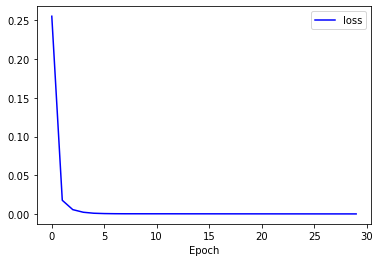

In [9]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
# test_x_array 각 샘플의 2시간 예측값이 기록되어 있는 test_pred_array shape 확인
print(test_pred_array.shape)

(529, 120, 1)


In [11]:
# 모델 저장 및 로드
model.save('./my_model.h5')
model = tf.keras.models.load_model('./my_model.h5')

In [12]:
# 매수 시점, 매수 비율 표 만들기
# 1) train_pred_array 3차원에서 2차원으로 바꾸기
pred_array_2d = np.zeros([test_pred_array.shape[0], 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    pred_array_2d[idx, :] = test_pred_array[idx, :, 0]

# 2) 예측값을 재해석하여 submission 표를 작성하는 함수 정의
def array_to_submission(pred_array):
    submission = pd.DataFrame(np.zeros([pred_array.shape[0], 2], np.int64),
                              columns=['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    sell_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        sell_price.append(pred_array[idx, sell_time])
    sell_price = np.array(sell_price)
    submission.loc[:, 'buy_quantity'] = ((1*1*(sell_price/1)*0.9995*0.9995) > 1.08)*1 #-DACON-Bit_Trader폴더 주가 손실계산.png 참고
    submission['sell_time'] = np.argmax(pred_array, axis=1)
    submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
    return submission, sell_price

final_submission, forecasted_max = array_to_submission(pred_array_2d)

100%|██████████| 529/529 [00:00<00:00, 12022.17it/s]


In [13]:
# 각 샘플의 예측치 중 최고값 모아 보기
forecasted_max

array([0.99501801, 1.01486981, 0.99830973, 0.97571051, 0.99047554,
       1.03973448, 0.97037011, 0.97886777, 0.991445  , 0.99018353,
       1.03164494, 0.97963518, 1.01512945, 0.98377258, 0.99765211,
       1.01097155, 1.013641  , 0.99804765, 1.02706528, 1.01977432,
       1.01053643, 0.98528504, 1.01479805, 1.07257426, 1.02404892,
       1.06676245, 1.07046163, 0.98367995, 0.98865837, 0.9822914 ,
       0.99546987, 1.01943862, 1.04829252, 0.97998101, 0.99988806,
       1.04390836, 0.98148334, 0.98892069, 1.00775325, 1.02631903,
       0.95775193, 0.98685282, 0.99804395, 1.02891243, 0.98071039,
       1.01150334, 0.99588788, 1.00433397, 0.99319404, 1.03255033,
       1.03137958, 0.97677964, 1.00810826, 0.99477994, 0.99052149,
       0.9807303 , 0.98483771, 0.9929179 , 1.01795101, 0.99747825,
       1.04755008, 0.98974431, 1.02883518, 0.98308575, 1.0137558 ,
       1.01251984, 0.97593844, 0.99732339, 1.05986166, 0.98669606,
       1.00834131, 1.02551651, 1.04443419, 0.94236261, 0.98820

In [14]:
# 전체 300가지 sample에 대해 _가지 case에서 (수수료 감안해서) 매수 시점(1380분)보다 108% 이상 상승한다고 예측함.
final_submission.buy_quantity.value_counts()

0    526
1      3
Name: buy_quantity, dtype: int64

In [15]:
# (수수료 감안하지 않고) 매수 시점보다 108% 이상 상승한다고 예측한 경우, 해당 예측치들 모아 보기
forecasted_max[forecasted_max >= 1.08]

array([1.09489202, 1.08033705, 1.12318075, 1.08358419])

---

매수할 샘플이 너무 적게 나왔을 경우 기준치를 보고 10개 내외로 재조정

In [23]:
import numpy as np

forcasted_max = np.array([0.99501801, 1.01486981, 0.99830973, 0.97571051, 0.99047554,
       1.03973448, 0.97037011, 0.97886777, 0.991445  , 0.99018353,
       1.03164494, 0.97963518, 1.01512945, 0.98377258, 0.99765211,
       1.01097155, 1.013641  , 0.99804765, 1.02706528, 1.01977432,
       1.01053643, 0.98528504, 1.01479805, 1.07257426, 1.02404892,
       1.06676245, 1.07046163, 0.98367995, 0.98865837, 0.9822914 ,
       0.99546987, 1.01943862, 1.04829252, 0.97998101, 0.99988806,
       1.04390836, 0.98148334, 0.98892069, 1.00775325, 1.02631903,
       0.95775193, 0.98685282, 0.99804395, 1.02891243, 0.98071039,
       1.01150334, 0.99588788, 1.00433397, 0.99319404, 1.03255033,
       1.03137958, 0.97677964, 1.00810826, 0.99477994, 0.99052149,
       0.9807303 , 0.98483771, 0.9929179 , 1.01795101, 0.99747825,
       1.04755008, 0.98974431, 1.02883518, 0.98308575, 1.0137558 ,
       1.01251984, 0.97593844, 0.99732339, 1.05986166, 0.98669606,
       1.00834131, 1.02551651, 1.04443419, 0.94236261, 0.98820508,
       1.00132418, 1.02492678, 1.00689685, 0.98573565, 1.00431824,
       0.99231249, 1.04444015, 1.01813722, 0.98707324, 0.99219155,
       0.99253553, 0.96476316, 0.96181041, 0.95555097, 1.03026545,
       0.96559244, 1.01499021, 0.98624706, 0.98353076, 1.0012027 ,
       0.99423963, 1.02290154, 1.09489202, 1.0123353 , 0.98654586,
       0.99075907, 0.99882108, 1.08033705, 1.01999092, 0.99478519,
       1.0132581 , 0.99445504, 1.0240519 , 0.98160571, 1.02051258,
       0.99880356, 0.9840799 , 1.01730037, 0.97515339, 1.018188  ,
       1.03644931, 0.96327245, 0.98197848, 1.04702568, 1.01030064,
       1.0525434 , 0.98666781, 0.98721504, 1.06053102, 1.05846334,
       1.01000905, 1.02403951, 0.99874103, 0.98075092, 0.95930839,
       0.98308671, 1.0025543 , 1.00444913, 1.01177239, 0.99657047,
       0.97157055, 0.97765481, 0.98601413, 0.99970239, 0.99031562,
       1.01492429, 1.02935898, 0.99436599, 0.95807546, 1.04942679,
       0.96180332, 0.99357682, 0.98485833, 0.99401772, 1.05271852,
       0.99457508, 1.02084935, 0.98892826, 0.97785103, 0.97922957,
       0.94527692, 0.97517008, 1.02085364, 1.04298449, 0.9707756 ,
       0.93047607, 1.00204623, 0.9788698 , 0.99293482, 0.97668874,
       0.98499912, 0.97602594, 0.98919779, 1.02871573, 0.99352562,
       0.98148292, 0.96918952, 0.97291607, 0.97068566, 0.98834306,
       0.96391547, 1.0195533 , 0.98841029, 1.00998414, 0.98108011,
       0.98489588, 1.01942372, 1.02967322, 0.98984528, 1.01419139,
       0.98073226, 1.00323582, 0.98796743, 0.99910259, 1.04018736,
       0.9899376 , 1.02693975, 1.02283847, 0.99145728, 0.9779985 ,
       1.00198066, 0.99782562, 1.02381885, 0.98603266, 0.98845625,
       1.0076493 , 1.01412797, 0.99566221, 1.02461374, 0.98482722,
       0.97027117, 0.98608077, 0.99748719, 1.02506995, 1.02314246,
       0.99521685, 1.03321218, 0.98861098, 0.98378021, 0.98611897,
       0.97842491, 0.99299002, 1.07155323, 0.98068047, 0.97828799,
       0.98158616, 0.9652068 , 1.01344883, 1.05512643, 1.02701354,
       1.00919569, 0.9740386 , 1.01858938, 1.04766095, 0.97609258,
       1.0123148 , 0.96089745, 1.01862073, 0.98749518, 0.96784103,
       0.99568129, 0.98130739, 1.02805138, 0.99395937, 1.03097045,
       1.03076434, 1.0180037 , 0.98073518, 0.98090923, 1.0387361 ,
       1.06196213, 0.98072284, 1.0002079 , 0.98034388, 0.95802766,
       1.00415993, 0.98045427, 0.9714092 , 0.98087388, 0.99843097,
       0.97619057, 1.03193665, 0.96294695, 1.05916059, 1.12318075,
       1.01037443, 1.05574059, 1.03980267, 0.99537838, 0.99820906,
       0.97784978, 1.04842687, 1.03719294, 1.02874684, 0.96977216,
       0.98640287, 0.9947207 , 0.98030275, 0.98048323, 1.01332247,
       1.00178087, 1.01265705, 1.02323234, 0.94479197, 0.95353335,
       1.01323617, 1.01907754, 0.97953981, 1.01563275, 0.96790344,
       0.99669933, 0.96565866, 1.00102568, 0.99249208, 0.99868935,
       0.99187344, 0.97868371, 1.00860298, 1.01834106, 1.0146693 ,
       0.98842472, 0.9885186 , 1.03510249, 0.97225761, 1.02304399,
       1.04629302, 1.02900052, 0.9969945 , 1.00043583, 0.99623239,
       0.98320305, 1.02098739, 1.08358419, 0.98004955, 0.98341751,
       0.99370313, 1.01348102, 1.04909945, 1.03312349, 0.98486298,
       0.99363554, 1.00214183, 0.99387985, 0.98520988, 0.97312117,
       0.95301741, 1.01988149, 0.96408653, 1.00810218, 1.0155772 ,
       1.05127883, 1.0045898 , 0.99757755, 0.98181754, 1.02371311,
       0.97638619, 0.99149066, 1.03401864, 0.97125852, 1.01511037,
       1.00986421, 1.01210308, 0.97900212, 0.96830487, 1.00573242,
       1.00258434, 0.99308842, 1.01627314, 0.98943269, 1.00359046,
       1.00654948, 0.98641139, 1.04227781, 0.99303067, 1.02947521,
       0.99838066, 1.07428169, 0.99122542, 1.03189731, 1.02388406,
       0.97464883, 0.99610823, 0.98215008, 0.98541898, 1.00504827,
       1.01172531, 0.99755627, 0.96309787, 1.05351365, 0.9800083 ,
       0.99191809, 1.03215253, 0.9779523 , 0.99664503, 1.04742777,
       1.01816869, 1.00217271, 1.00408792, 0.99401975, 0.98890024,
       1.02969825, 1.00355566, 1.0231663 , 1.00670755, 1.0009408 ,
       1.05164635, 1.03491211, 0.99103665, 1.01800907, 0.98550898,
       1.0560509 , 1.02166152, 1.00485837, 0.97379512, 0.97317785,
       1.00451458, 1.02975833, 0.97973859, 0.99127096, 0.98666084,
       0.98252398, 0.98324442, 1.01856196, 1.03193617, 0.96743923,
       0.96072143, 1.0189451 , 1.00715625, 0.98437274, 0.97583312,
       0.9974196 , 0.99094677, 1.03431332, 1.07151186, 1.02400005,
       0.9741953 , 1.05653489, 1.073452  , 1.02205408, 0.98381358,
       1.0405699 , 1.04899609, 1.06661761, 0.97422379, 1.0145098 ,
       0.9726696 , 0.97581607, 1.01503587, 0.98331207, 1.06927502,
       0.98242599, 0.98150164, 1.05740666, 1.02499533, 0.99751937,
       0.99636161, 1.02081704, 1.02085066, 0.99483496, 1.01975751,
       0.98520732, 0.98178083, 0.98795807, 0.98499286, 1.00830019,
       0.97667134, 1.00299716, 0.97593451, 1.01943731, 1.04813313,
       1.00123465, 1.04480457, 1.01562405, 0.98921973, 1.02258229,
       0.99508184, 1.03496897, 1.00229228, 0.98620176, 1.06350827,
       0.97879654, 0.99246842, 1.07071853, 0.96426284, 0.99344605,
       1.02891636, 1.00148034, 0.99219787, 1.02545726, 0.99575174,
       0.99842775, 1.01613677, 1.00444019, 1.03159165, 0.98245698,
       1.03707695, 0.96631199, 1.03952479, 0.98351616, 1.04243934,
       0.97451162, 0.98207295, 0.98494965, 0.99070448, 1.00097561,
       0.95645642, 0.97905886, 1.01797283, 0.97238958, 0.99450868,
       0.99478906, 0.99288696, 1.00958467, 0.99592072, 0.99364269,
       0.97419715, 1.00328219, 0.96054274, 0.96577537, 0.99236405,
       1.03112459, 1.00463986, 1.04090309, 0.98966455, 0.98927808,
       0.98816723, 1.00216663, 0.97077239, 0.99428445, 1.00297332,
       1.02854216, 1.01815403, 1.01117456, 0.97453111, 0.98708779,
       1.01239145, 0.99474782, 0.9759596 , 0.99430746, 1.01361084,
       1.01131904, 0.99731964, 1.03766632, 0.99965495, 1.03003728,
       0.97627896, 1.04619622, 0.97919273, 1.02101612, 0.99911952,
       1.00487065, 1.00850534, 0.99515194, 0.99262035])

In [24]:
len(forcasted_max)

529

In [31]:
l = []
for i in forcasted_max[forcasted_max>=1.07]:
    l.append(i)
l

[1.07257426,
 1.07046163,
 1.09489202,
 1.08033705,
 1.07155323,
 1.12318075,
 1.08358419,
 1.07428169,
 1.07151186,
 1.073452,
 1.07071853]

In [32]:
for j in l:
    print(np.where(forcasted_max == j))

(array([23], dtype=int64),)
(array([26], dtype=int64),)
(array([97], dtype=int64),)
(array([102], dtype=int64),)
(array([217], dtype=int64),)
(array([259], dtype=int64),)
(array([307], dtype=int64),)
(array([351], dtype=int64),)
(array([408], dtype=int64),)
(array([412], dtype=int64),)
(array([457], dtype=int64),)


In [33]:
# final_submission csv파일로 저장
final_submission.to_csv('./submission.csv', index = False)

---

In [17]:
# 모델 평가: test_x데이터로 예측하는 방식을 입력값(train_x)에 대한 예측값과 실제값(train_y_array) 비교를 통해 평가

train_pred_array = np.zeros([1, 120, 1])

sample = 100  #평가용 임의의 샘플 id

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience= 3, min_lr = 0)

ep = 30
bs = 120
# train_x_array데이터로 시계열 Windows 만들기
# idx에 해당하는 샘플 하나만 학습하므로 for loop는 한 번만 돌아감
for idx in range(sample, sample+1):
    seq_len = 180  # window_size와 같은 개념
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(train_x_array[idx, :, 1][index: index + sequence_length])

    # x_train, y_train 데이터 구성
    windows = np.array(windows) #1329 * 121의 2차원 배열
    x_train = windows[:, :-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = windows[:, -1]

    
    # Fit(early_stoppage & reduceLR 적용)
    model = build_model()
    history = model.fit(x_train, y_train, validation_split=0.1, epochs = ep, batch_size = bs, verbose = 2, callbacks = [early_stop, reduceLR])
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력

    # train_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]
    window_3d = np.reshape(window, (1, window.shape[0], 1))
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 train_pred_array에 기록
        train_pred_array[:, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = train_pred_array[:, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # train_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        # 이렇게 predict매서드에 들어갈 수 있는 형태로 만들어 줌으로써 얻은 이점: 1. Loop 돌리는 것 가능, 2. window가 이동하여 test_x의 마지막 윈도우의 값이 더 이상 남아 있지 않아도, 예상값들로만 새롭게 window를 구성하여 입력하는 방식으로 구현할 수 있게 해줌. 
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

Train on 1079 samples, validate on 120 samples
Epoch 1/30
1079/1079 - 6s - loss: 0.3215 - mse: 0.3215 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 2/30
1079/1079 - 0s - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 3/30
1079/1079 - 0s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/30
1079/1079 - 0s - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/30
1079/1079 - 0s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 6/30
1079/1079 - 0s - loss: 6.8030e-04 - mse: 6.8030e-04 - val_loss: 4.5421e-05 - val_mse: 4.5421e-05
Epoch 7/30
1079/1079 - 0s - loss: 3.5432e-04 - mse: 3.5432e-04 - val_loss: 5.8839e-04 - val_mse: 5.8839e-04
Epoch 8/30
1079/1079 - 0s - loss: 2.0143e-04 - mse: 2.0143e-04 - val_loss: 1.0132e-04 - val_mse: 1.0132e-04
Epoch 9/30
1079/1079 - 0s - loss: 1.3912e-04 - mse: 1.3912e-04 - val_loss: 3.0585e-04 - val_mse: 3.0585e-04
Epoch 10/30
1079/1079 - 0s - loss: 1.1121e-04 - mse: 1.1121e-

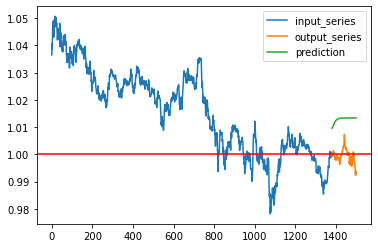

In [18]:
# train 샘플 훈련 성과 시각화해보기
# 1) 입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 정의
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# 2) train data 중 sample_id idx에 해당하는 x_series로 모델을 학습한 후 y_series를 추론
x_series = train_x_array[sample,:,1]
y_series = train_y_array[sample,:,1]
plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), train_pred_array[0,:,0], label = 'prediction')
plt.legend()
plt.show()

In [19]:
train_pred_array

array([[[1.00959551],
        [1.00969493],
        [1.00981462],
        [1.00995541],
        [1.01011479],
        [1.01028848],
        [1.01047122],
        [1.01065874],
        [1.01084673],
        [1.01103139],
        [1.01121032],
        [1.01138151],
        [1.01154339],
        [1.01169562],
        [1.01183748],
        [1.01196909],
        [1.0120908 ],
        [1.01220262],
        [1.01230538],
        [1.01239955],
        [1.0124855 ],
        [1.01256418],
        [1.01263607],
        [1.01270139],
        [1.01276112],
        [1.01281536],
        [1.01286495],
        [1.01290989],
        [1.0129509 ],
        [1.01298821],
        [1.01302218],
        [1.01305306],
        [1.01308119],
        [1.01310682],
        [1.01313031],
        [1.01315141],
        [1.01317084],
        [1.01318836],
        [1.01320457],
        [1.013219  ],
        [1.01323235],
        [1.01324451],
        [1.01325548],
        [1.01326549],
        [1.01327479],
        [1

In [20]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index

def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

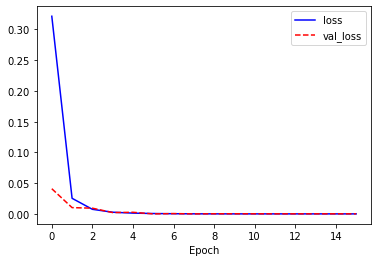

In [21]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [22]:
total_momey, total_momey_list = COIN(train_y_df,
                                     train_pred_array)
print(total_momey)

AttributeError: 'numpy.ndarray' object has no attribute 'set_index'

---

In [ ]:
# train_x_df의 자료들을 학습에 활용하게 될 경우:
# train_x_df를 sample_id을 기준으로 추출하는 방법
train_x_df = train_x_df[train_x_df.sample_id < 300]
train_y_df = train_y_df[train_y_df.sample_id < 300]